In [1]:
import pandas as pd
import numpy as np
import os
import re
import ast
from itertools import product

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from keras.utils import to_categorical, set_random_seed

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


import pickle
from json import loads, dumps

from scipy.signal import find_peaks

file.split('__')[-1].rstrip('.csv')

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr  2 12:28:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
os.getcwd()

'/content'

In [5]:
os.listdir()

['.config', 'sample_data']

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
os.listdir()

['.config', 'drive', 'sample_data']

In [8]:
os.listdir('drive/MyDrive/students 2024 big data')

['Actuals Aubagne 21June 15cm2',
 'runs emse 10july 15cm2 25dBm',
 'Deep_Learning (1).ipynb',
 'lstm_EPC.h5',
 'Deep_Learning_Clean (1).ipynb',
 'Untitled0.ipynb',
 'LSTM_STATICANDDYNAMICFEATV6.ipynb',
 'students 2024 big data 30Jan2024.ipynb',
 'clo students 2024 big data LSTM 13Feb2024.ipynb',
 'clf_EPC.pkl',
 'best_epoch.h5',
 'svc rbf.pkl',
 'svc linear.pkl',
 '_.pkl',
 'runs tagsys 26March2024 antSep=1__antPitch=45',
 'runs tagsys 26March2024 antSep=0.4__antPitch=45',
 'Actuals tagsys 26March2024',
 'temp',
 'runs tagsys 27March2024 antSep=1__antPitch=45',
 'runs tagsys 27March2024 antSep=1__antPitch=20_45',
 'clf_EPC_gpio.pkl',
 'students 2024 big data NEW 2Avril2024.ipynb']

In [9]:
%cd 'drive/MyDrive/students 2024 big data'

/content/drive/MyDrive/students 2024 big data


# RFID data

## pathfiles

In [10]:
pathfile_runs = 'runs emse 10july 15cm2 25dBm'
pathfile_Actuals='Actuals Aubagne 21June 15cm2'

# pathfile_runs = 'runs tagsys 26March2024 antSep=1__antPitch=45'
# pathfile_runs = 'runs tagsys 27March2024 antSep=1__antPitch=20_45'

# pathfile_runs = 'runs tagsys 26March2024 antSep=0.4__antPitch=45'
# pathfile_runs = 'runs tagsys 27March2024 antSep=1__antPitch=45'
# pathfile_Actuals='Actuals tagsys 26March2024'

## raw RFID: tags, Runs, gpio

In [11]:
Cols = ['Timestamp', 'EPC', 'TID', 'Antenna', 'RSSI', 'Frequency', 'Hostname', 'PhaseAngle', 'DopplerFrequency']
tags = pd.DataFrame()
Runs = []
actualDyn = pd.DataFrame()

for file in os.listdir(pathfile_runs):
  print(file)
# run_settings
  with open(os.path.join(pathfile_runs, file)) as f:
    run = f.readline()
    reader_settings_temp = f.readline()
  #   Cols = f.readline()
  #   #
    run = pd.to_datetime(run.lstrip('// ').rstrip('\n'))
    reader_settings_temp = reader_settings_temp.lstrip('// ').rstrip('\n').split(', ')
    reader_settings_temp = {x.split('=')[0]:x.split('=')[1] for x in reader_settings_temp}
  #   Cols = Cols.lstrip('// ').rstrip('\n').split(', ')
  run_settings_temp = [x.split('=') for x in file.split('__')[:-1] ]
  run_settings_temp = {key:value for key, value in run_settings_temp}
  run_settings_temp['run']=run

  settings_temp = {**run_settings_temp, **reader_settings_temp}
# tags_temp
  filename = os.path.join(pathfile_runs, file)
  tags_temp = pd.read_csv(filename, sep=';', skiprows=3, names=Cols)
  tags_temp['run']=run

  # for key, value in settings.items():
  #   tags_temp[key] = value

  print(tags_temp.shape)

  tags = pd.concat([tags, tags_temp], axis=0)
  Runs.append(settings_temp)



# tags = tags.drop(columns=['TID', 'Frequency', 'Hostname', 'PhaseAngle', 'DopplerFrequency'])

Runs = pd.DataFrame(Runs)
tags.head()

actualDyn=[[P,1,1,-1,curved,2],[N,2,1,1,none,2]]__speed=1__antCov=1in2in3out4out__antGain=8dBiC__antTilt=45__antLoc=floor__site=emse__07-10-2023_12h_58m_43s (3).csv
(39523, 10)
actualDyn=[[P,1,1,-1,curved,2],[N,2,1,5,curved,2]]__speed=1__antCov=1in2in3out4out__antGain=8dBiC__antTilt=45__antLoc=floor__site=emse__07-10-2023_14h_52m_02s (2).csv
(37164, 10)
actualDyn=[[P,1,2,-2,curved,2],[N,2,2,2,none,2]]__speed=1__antCov=1in2in3out4out__antGain=8dBiC__antTilt=45__antLoc=floor__site=emse__07-10-2023_13h_03m_27s (5).csv
(37980, 10)
actualDyn=[[P,1,2,-2,curved,2],[N,2,2,5,curved,2]]__speed=1__antCov=1in2in3out4out__antGain=8dBiC__antTilt=45__antLoc=floor__site=emse__07-10-2023_13h_47m_12s (2).csv
(31352, 10)
actualDyn=[[P,1,3,-3,curved,2],[N,2,3,3,none,2]]__speed=1__antCov=1in2in3out4out__antGain=8dBiC__antTilt=45__antLoc=floor__site=emse__07-10-2023_13h_08m_43s (3).csv
(31652, 10)
actualDyn=[[P,1,3,-3,curved,2],[N,2,3,5,curved,2]]__speed=1__antCov=1in2in3out4out__antGain=8dBiC__antTilt=45__

,Timestamp,EPC,TID,Antenna,RSSI,Frequency,Hostname,PhaseAngle,DopplerFrequency,run
0,#2023-07-10T12:58:45.5666792+02:00 GPI Event P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-07 12:58:43
1,#2023-07-10T12:58:45.5667442+02:00 GPI Event P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-07 12:58:43
2,#2023-07-10T12:58:45.5667655+02:00 GPI Event P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-07 12:58:43
3,#2023-07-10T12:58:45.5667830+02:00 GPI Event P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-07 12:58:43
4,#2023-07-10T12:58:45.6466940+02:00 GPI Event P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-07 12:58:43


In [12]:
Runs = Runs.sort_values('run').reset_index(drop=True)
Runs

,actualDyn,speed,antCov,antGain,antTilt,antLoc,site,run,ReaderName,AntennaIDs,InventoryMode,ModeIndex,Population,PowerInDbm,Session
0,"[[P,1,1,-1,curved,2],[N,2,1,1,none,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 12:58:43,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
1,"[[P,1,2,-2,curved,2],[N,2,2,2,none,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:03:27,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
2,"[[P,1,3,-3,curved,2],[N,2,3,3,none,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:08:43,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
3,"[[P,1,4,-4,curved,2],[N,2,4,4,none,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:14:00,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
4,"[[P,1,5,-5,curved,2],[N,2,5,5,none,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:19:22,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
5,"[[P,1,2,-2,curved,2],[N,2,2,5,curved,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:47:12,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
6,"[[P,1,3,-3,curved,2],[N,2,3,5,curved,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:51:05,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
7,"[[P,1,4,-4,curved,2],[N,2,4,5,curved,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:56:19,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
8,"[[P,1,5,-5,curved,2],[N,2,5,5,curved,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 14:01:18,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
9,"[[P,1,1,-1,curved,2],[N,2,1,5,curved,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 14:52:02,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1


In [13]:
def func(x):
  gpio = x [ x['Timestamp'].str.startswith('#') ] [['Timestamp']]
  gpio['status'] = gpio['Timestamp'].apply(lambda x:x.split(' ')[-3])
  gpio['Timestamp'] = gpio['Timestamp'].apply(lambda x:x.split(' ')[-1])
  gpio['Timestamp'] = pd.to_datetime(gpio['Timestamp'])

  gpio['Delta'] = (gpio['Timestamp'] - gpio['Timestamp'].shift(1)).dt.total_seconds()
  gpio['crossing_id'] = (gpio['Delta'] > 1).cumsum()
  gpio = gpio.groupby('crossing_id') ['Timestamp'].mean().reset_index(drop=False).rename(columns={'Timestamp': 'gpioCenter'})
  # crossing_id=0: manual start
  gpio = gpio [gpio['crossing_id']!=0]

  return gpio
gpio = tags.groupby('run').apply(func) .reset_index(drop=False) .drop(columns=['level_1'])
gpio

,run,crossing_id,gpioCenter
0,2023-10-07 12:58:43,1,2023-07-10 12:58:54.835649280+02:00
1,2023-10-07 12:58:43,2,2023-07-10 12:59:07.112151808+02:00
2,2023-10-07 12:58:43,3,2023-07-10 12:59:19.229456128+02:00
3,2023-10-07 12:58:43,4,2023-07-10 12:59:30.500352512+02:00
4,2023-10-07 12:58:43,5,2023-07-10 12:59:42.917996288+02:00
5,2023-10-07 12:58:43,6,2023-07-10 12:59:52.958400256+02:00
6,2023-10-07 13:03:27,1,2023-07-10 13:03:39.872558336+02:00
7,2023-10-07 13:03:27,2,2023-07-10 13:03:52.498925056+02:00
8,2023-10-07 13:03:27,3,2023-07-10 13:04:07.487812096+02:00
9,2023-10-07 13:03:27,4,2023-07-10 13:04:20.329154560+02:00


In [14]:
gpio.groupby('run').size().mean()

6.0

## tags

In [15]:
tags = tags [ ~tags['Timestamp'].str.startswith('#') ] [['run', 'Timestamp', 'EPC', 'Antenna', 'RSSI']]
tags

,run,Timestamp,EPC,Antenna,RSSI
8,2023-10-07 12:58:43,2023-07-10T12:58:45.6004100+02:00,AD3830770CCDD0AD383002AA,1.0,"-56,5"
9,2023-10-07 12:58:43,2023-07-10T12:58:45.6004100+02:00,AD3830770CCDD0AD383002AA,1.0,"-56,5"
10,2023-10-07 12:58:43,2023-07-10T12:58:45.6004100+02:00,AD3830770CCDD0AD383002AA,1.0,"-56,5"
11,2023-10-07 12:58:43,2023-07-10T12:58:45.6004100+02:00,AD3830770CCDD0AD383002AA,1.0,"-56,5"
12,2023-10-07 12:58:43,2023-07-10T12:58:45.6035870+02:00,AD3830770CCDD0AD38300333,1.0,"-62,5"
...,...,...,...,...,...
27027,2023-10-07 13:19:22,2023-07-10T13:21:11.3135220+02:00,AD3830770CCDD0AD383002FC,1.0,"-68,5"
27028,2023-10-07 13:19:22,2023-07-10T13:21:11.3220210+02:00,AD3830770CCDD0AD383002C3,1.0,"-67,5"
27029,2023-10-07 13:19:22,2023-07-10T13:21:11.3220210+02:00,AD3830770CCDD0AD383002C3,1.0,"-67,5"
27030,2023-10-07 13:19:22,2023-07-10T13:21:11.3220210+02:00,AD3830770CCDD0AD383002C3,1.0,"-67,5"


In [16]:
tags.shape, tags.drop_duplicates(['EPC', 'Timestamp']).shape

((325831, 5), (81458, 5))

In [17]:
tags = tags.drop_duplicates(['EPC', 'Timestamp']).reset_index(drop=True)
tags.head()

,run,Timestamp,EPC,Antenna,RSSI
0,2023-10-07 12:58:43,2023-07-10T12:58:45.6004100+02:00,AD3830770CCDD0AD383002AA,1.0,"-56,5"
1,2023-10-07 12:58:43,2023-07-10T12:58:45.6035870+02:00,AD3830770CCDD0AD38300333,1.0,"-62,5"
2,2023-10-07 12:58:43,2023-07-10T12:58:45.6093160+02:00,AD3830770CCDD0AD38300337,1.0,-58
3,2023-10-07 12:58:43,2023-07-10T12:58:45.6134580+02:00,AD3830770CCDD0AD383002DC,1.0,"-63,5"
4,2023-10-07 12:58:43,2023-07-10T12:58:45.6167160+02:00,AD3830770CCDD0AD3830020E,1.0,"-63,5"


## formatting

In [18]:
tags['RSSI'] = tags['RSSI'].str.replace(',', '.').astype(float)
tags['RSSIdBm'] = tags['RSSI']
tags['RSSI'] = 10**6 * 10**(tags['RSSIdBm']/10)

tags['Timestamp'] = pd.to_datetime(tags['Timestamp'])

tags['Antenna'] = tags['Antenna'].astype(int)

tags = tags.sort_values('Timestamp', ascending=True).reset_index(drop=True)

tags.head()

,run,Timestamp,EPC,Antenna,RSSI,RSSIdBm
0,2023-10-07 12:58:43,2023-07-10 12:58:45.600410+02:00,AD3830770CCDD0AD383002AA,1,2.238721,-56.5
1,2023-10-07 12:58:43,2023-07-10 12:58:45.603587+02:00,AD3830770CCDD0AD38300333,1,0.562341,-62.5
2,2023-10-07 12:58:43,2023-07-10 12:58:45.609316+02:00,AD3830770CCDD0AD38300337,1,1.584893,-58.0
3,2023-10-07 12:58:43,2023-07-10 12:58:45.613458+02:00,AD3830770CCDD0AD383002DC,1,0.446684,-63.5
4,2023-10-07 12:58:43,2023-07-10 12:58:45.616716+02:00,AD3830770CCDD0AD3830020E,1,0.446684,-63.5


In [19]:
tags.dtypes

run                                 datetime64[ns]
Timestamp    datetime64[ns, pytz.FixedOffset(120)]
EPC                                         object
Antenna                                      int64
RSSI                                       float64
RSSIdBm                                    float64
dtype: object

## Actuals

In [20]:
Cols = ['EPC']
Actuals=pd.DataFrame()

for file in os.listdir(pathfile_Actuals):

    filename = os.path.join(pathfile_Actuals, file)
    Actuals_temp = pd.read_csv(filename, sep=';', names=Cols)

    Actuals_settings = [x.split('=') for x in file.rstrip('.csv').split('__')]

    if Actuals_settings:
      Actuals_settings = {key:value for (key, value) in Actuals_settings}

      for key, value in Actuals_settings.items():
        Actuals_temp[key]= value

    Actuals = pd.concat([Actuals, Actuals_temp], axis=0)
Actuals = Actuals.reset_index(drop=True) # [['EPC', 'actual']]
Actuals

,EPC,actual,actual_id,size
0,AD3830770CCDD0AD383004A9,N,2,15
1,AD3830770CCDD0AD38300309,N,2,15
2,AD3830770CCDD0AD383002C3,N,2,15
3,AD3830770CCDD0AD38300363,N,2,15
4,AD3830770CCDD0AD3830021C,N,2,15
...,...,...,...,...
195,AD3830770CCDD0AD3830021B,P,1,15
196,AD3830770CCDD0AD383004B3,P,1,15
197,AD3830770CCDD0AD383004AA,P,1,15
198,AD3830770CCDD0AD383004B1,P,1,15


In [21]:
Actuals.groupby(['actual']).size()

actual
N    100
P    100
dtype: int64

## merge tags, Actuals

In [22]:
tags = pd.merge(tags, Actuals, on='EPC', how='inner' )
tags.head()

,run,Timestamp,EPC,Antenna,RSSI,RSSIdBm,actual,actual_id,size
0,2023-10-07 12:58:43,2023-07-10 12:58:45.600410+02:00,AD3830770CCDD0AD383002AA,1,2.238721,-56.5,N,2,15
1,2023-10-07 12:58:43,2023-07-10 12:58:47.213407+02:00,AD3830770CCDD0AD383002AA,2,2.238721,-56.5,N,2,15
2,2023-10-07 12:58:43,2023-07-10 12:58:48.880130+02:00,AD3830770CCDD0AD383002AA,1,2.818383,-55.5,N,2,15
3,2023-10-07 12:58:43,2023-07-10 12:58:50.502690+02:00,AD3830770CCDD0AD383002AA,1,1.995262,-57.0,N,2,15
4,2023-10-07 12:58:43,2023-07-10 12:58:52.138463+02:00,AD3830770CCDD0AD383002AA,1,1.778279,-57.5,N,2,15


## artificial errors

In [23]:
# tags_artificial_errors.head()

In [24]:
# tags_artificial_errors.shape, tags.shape

In [25]:
# tags = pd.concat([tags, tags_artificial_errors]).sort_values(['Timestamp']).reset_index(drop=True)
# tags.shape

## Antenna_coverage

In [26]:
Antenna_coverage_dict = {1:'in', 2:'in', 3:'out', 4:'out'}
tags ['Antenna_coverage'] = tags['Antenna'].map(Antenna_coverage_dict)
tags

,run,Timestamp,EPC,Antenna,RSSI,RSSIdBm,actual,actual_id,size,Antenna_coverage
0,2023-10-07 12:58:43,2023-07-10 12:58:45.600410+02:00,AD3830770CCDD0AD383002AA,1,2.238721,-56.5,N,2,15,in
1,2023-10-07 12:58:43,2023-07-10 12:58:47.213407+02:00,AD3830770CCDD0AD383002AA,2,2.238721,-56.5,N,2,15,in
2,2023-10-07 12:58:43,2023-07-10 12:58:48.880130+02:00,AD3830770CCDD0AD383002AA,1,2.818383,-55.5,N,2,15,in
3,2023-10-07 12:58:43,2023-07-10 12:58:50.502690+02:00,AD3830770CCDD0AD383002AA,1,1.995262,-57.0,N,2,15,in
4,2023-10-07 12:58:43,2023-07-10 12:58:52.138463+02:00,AD3830770CCDD0AD383002AA,1,1.778279,-57.5,N,2,15,in
...,...,...,...,...,...,...,...,...,...,...
80450,2023-10-07 14:52:02,2023-07-10 14:52:59.981150+02:00,AD3830770CCDD0AD383002C7,1,0.562341,-62.5,N,2,15,in
80451,2023-10-07 14:52:02,2023-07-10 14:53:02.032191+02:00,AD3830770CCDD0AD383002C7,2,0.446684,-63.5,N,2,15,in
80452,2023-10-07 14:52:02,2023-07-10 14:53:06.589608+02:00,AD3830770CCDD0AD383002C7,1,0.316228,-65.0,N,2,15,in
80453,2023-10-07 14:52:02,2023-07-10 14:53:08.226442+02:00,AD3830770CCDD0AD383002C7,1,0.223872,-66.5,N,2,15,in


## Slots

In [27]:
def func(df):
    Tmin = df['Timestamp'].min()
    Tmax = df['Timestamp'].max()
    Slots = pd.DataFrame({'slotStart':pd.date_range(start=Tmin, end=Tmax, freq='1s')})
#     Slots['slot_id']=range(len(Slots))
    return Slots

Slots = tags.groupby('run').apply(func).reset_index(drop=False).rename(columns={'level_1':'slot_id'})
Slots['slot_id'] = Slots['slot_id'].astype('int32')
Slots.head()

,run,slot_id,slotStart
0,2023-10-07 12:58:43,0,2023-07-10 12:58:45.600410+02:00
1,2023-10-07 12:58:43,1,2023-07-10 12:58:46.600410+02:00
2,2023-10-07 12:58:43,2,2023-07-10 12:58:47.600410+02:00
3,2023-10-07 12:58:43,3,2023-07-10 12:58:48.600410+02:00
4,2023-10-07 12:58:43,4,2023-07-10 12:58:49.600410+02:00


In [28]:
Slots.groupby('run') ['slot_id'].describe()

,count,mean,std,min,25%,50%,75%,max
run,,,,,,,,
2023-10-07 12:58:43,78.0,38.5,22.660538,0.0,19.25,38.5,57.75,77.0
2023-10-07 13:03:27,90.0,44.5,26.124701,0.0,22.25,44.5,66.75,89.0
2023-10-07 13:08:43,106.0,52.5,30.743563,0.0,26.25,52.5,78.75,105.0
2023-10-07 13:14:00,109.0,54.0,31.609598,0.0,27.00,54.0,81.00,108.0
2023-10-07 13:19:22,107.0,53.0,31.032241,0.0,26.50,53.0,79.50,106.0
2023-10-07 13:47:12,74.0,36.5,21.505813,0.0,18.25,36.5,54.75,73.0
2023-10-07 13:51:05,88.0,43.5,25.547342,0.0,21.75,43.5,65.25,87.0
2023-10-07 13:56:19,94.0,46.5,27.279418,0.0,23.25,46.5,69.75,93.0
2023-10-07 14:01:18,105.0,52.0,30.454885,0.0,26.00,52.0,78.00,104.0


## visu

In [29]:
def visu(df, EPC, bool_crossing, bool_gpio):

    Tmin=df['Timestamp'].min()
    Tmax=df['Timestamp'].max()
    RSSImin=df['RSSIdBm'].min()
    RSSImax=df['RSSIdBm'].max()

    if EPC!='all':
        df = df [ df['EPC']==EPC ]

    plt.figure(figsize=(14,6))

    dict_Antenna_coverage = {'in':'blue','mid':'black', 'out':'red'}
    dict_actual = {'P':'o', 'N':'+'}

    for key, df_key in df.groupby(['Antenna_coverage', 'actual']):
        Antenna_coverage = key[0]
        actual = key[1]
        c = dict_Antenna_coverage[Antenna_coverage]
        m = dict_actual [actual]
        sns.scatterplot(data=df_key, x='Timestamp', y='RSSIdBm', color=c, marker=m)
#
    Slots_df = Slots [ (Slots['slotStart']>Tmin) & (Slots['slotStart']<Tmax) ]
    slot_min=Slots_df['slot_id'].min()
    slot_max=Slots_df['slot_id'].max()
    plt.vlines(Slots_df['slotStart'] , ymin=RSSImin, ymax=RSSImax, linestyle='dashed', linewidth=0.5, color='k')
    for i, row in Slots_df.iterrows():
        slotStart=row['slotStart']
        slot_id=row['slot_id']
        plt.annotate(slot_id, (slotStart, RSSImin))
    if bool_crossing:
        slotStart = Slots_df [ Slots_df['slot_id_norm']==0 ] ['slotStart']
        plt.vlines(slotStart , ymin=RSSImin, ymax=RSSImax, linestyle='solid')
        for i, row in Slots_df.iterrows():
            slot_id_norm = row['slot_id_norm']
            slotStart = row['slotStart']
            plt.annotate(slot_id_norm, (slotStart, RSSImax))
    if bool_gpio:
        gpio_run = gpio [ (gpio['gpioStart']>Tmin) & (gpio['gpioStop']<Tmax) ]
        plt.vlines(gpio_run['gpioStart'] , ymin=RSSImin, ymax=RSSImax, linestyle='dashed', color='blue')
        plt.vlines(gpio_run['gpioStop'] , ymin=RSSImin, ymax=RSSImax, linestyle='dashed', color='blue')
        plt.vlines(gpio_run['gpioCenter'] , ymin=RSSImin, ymax=RSSImax, linestyle='solid', color='blue')

    run = df['run'].values[0]
    run = pd.to_datetime(run, format='%Y-%m-%d %H:%M:%S')
    title=f'run: {run}, EPC: {EPC}'
    if bool_crossing:
        Crossings_id = '_'.join([str(x) for x in Slots_df['crossing_id'].unique()])
        title=f'{title}, Crossings_id: {Crossings_id}'
    plt.title(f'{title}', size=14)
    plt.xlim([Tmin, Tmax])
    plt.show()

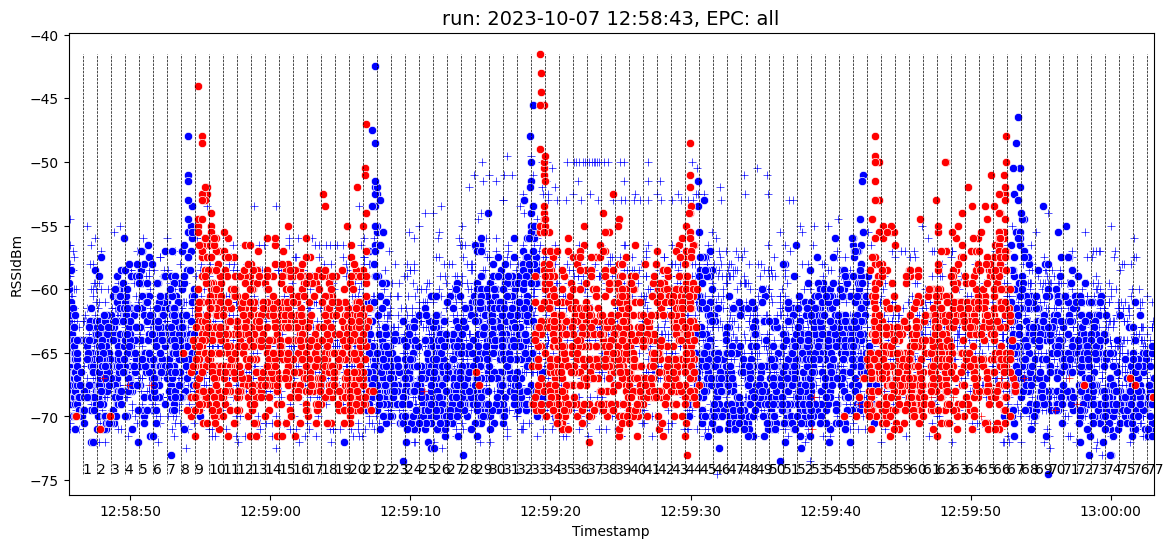

In [30]:
for run in tags['run'].unique()[:1] :
    tags_run = tags [ tags['run']==run ]
    visu(tags_run, 'all', False, False)

## merge gpio Slots (slot_crossing)

In [31]:
gpio = pd.merge_asof(gpio, Slots[['slot_id', 'slotStart']], left_on='gpioCenter', right_on='slotStart', direction='nearest').rename(columns={'slot_id':'slot_crossing'}).drop(columns=['slotStart'])
gpio.head()

,run,crossing_id,gpioCenter,slot_crossing
0,2023-10-07 12:58:43,1,2023-07-10 12:58:54.835649280+02:00,9
1,2023-10-07 12:58:43,2,2023-07-10 12:59:07.112151808+02:00,22
2,2023-10-07 12:58:43,3,2023-07-10 12:59:19.229456128+02:00,34
3,2023-10-07 12:58:43,4,2023-07-10 12:59:30.500352512+02:00,45
4,2023-10-07 12:58:43,5,2023-07-10 12:59:42.917996288+02:00,57


In [32]:
gpio[:8]

,run,crossing_id,gpioCenter,slot_crossing
0,2023-10-07 12:58:43,1,2023-07-10 12:58:54.835649280+02:00,9
1,2023-10-07 12:58:43,2,2023-07-10 12:59:07.112151808+02:00,22
2,2023-10-07 12:58:43,3,2023-07-10 12:59:19.229456128+02:00,34
3,2023-10-07 12:58:43,4,2023-07-10 12:59:30.500352512+02:00,45
4,2023-10-07 12:58:43,5,2023-07-10 12:59:42.917996288+02:00,57
5,2023-10-07 12:58:43,6,2023-07-10 12:59:52.958400256+02:00,67
6,2023-10-07 13:03:27,1,2023-07-10 13:03:39.872558336+02:00,10
7,2023-10-07 13:03:27,2,2023-07-10 13:03:52.498925056+02:00,23


## merge_asof Slots, gpio

In [33]:
Slots.head()

,run,slot_id,slotStart
0,2023-10-07 12:58:43,0,2023-07-10 12:58:45.600410+02:00
1,2023-10-07 12:58:43,1,2023-07-10 12:58:46.600410+02:00
2,2023-10-07 12:58:43,2,2023-07-10 12:58:47.600410+02:00
3,2023-10-07 12:58:43,3,2023-07-10 12:58:48.600410+02:00
4,2023-10-07 12:58:43,4,2023-07-10 12:58:49.600410+02:00


In [34]:
gpio.head()

,run,crossing_id,gpioCenter,slot_crossing
0,2023-10-07 12:58:43,1,2023-07-10 12:58:54.835649280+02:00,9
1,2023-10-07 12:58:43,2,2023-07-10 12:59:07.112151808+02:00,22
2,2023-10-07 12:58:43,3,2023-07-10 12:59:19.229456128+02:00,34
3,2023-10-07 12:58:43,4,2023-07-10 12:59:30.500352512+02:00,45
4,2023-10-07 12:58:43,5,2023-07-10 12:59:42.917996288+02:00,57


In [35]:
def func(x):
  run=x['run'].values[0]
  gpio_run = gpio [ gpio['run']==run ]
  temp = pd.merge_asof(x, gpio_run.drop(columns=['run']) , left_on='slot_id', right_on='slot_crossing', direction='nearest')
  return temp
Slots = Slots.groupby('run', group_keys=False).apply(func).drop(columns=['gpioCenter'])
Slots.head()

,run,slot_id,slotStart,crossing_id,slot_crossing
0,2023-10-07 12:58:43,0,2023-07-10 12:58:45.600410+02:00,1,9
1,2023-10-07 12:58:43,1,2023-07-10 12:58:46.600410+02:00,1,9
2,2023-10-07 12:58:43,2,2023-07-10 12:58:47.600410+02:00,1,9
3,2023-10-07 12:58:43,3,2023-07-10 12:58:48.600410+02:00,1,9
4,2023-10-07 12:58:43,4,2023-07-10 12:58:49.600410+02:00,1,9


## nocrossing_id

In [36]:
NoCrossings = gpio[['run', 'crossing_id', 'slot_crossing']] .rename(columns={'crossing_id': 'nocrossing_id', 'slot_crossing': 'slot_crossing_next'})
NoCrossings[:6]

,run,nocrossing_id,slot_crossing_next
0,2023-10-07 12:58:43,1,9
1,2023-10-07 12:58:43,2,22
2,2023-10-07 12:58:43,3,34
3,2023-10-07 12:58:43,4,45
4,2023-10-07 12:58:43,5,57
5,2023-10-07 12:58:43,6,67


In [37]:
NoCrossings.dtypes

run                   datetime64[ns]
nocrossing_id                  int64
slot_crossing_next             int32
dtype: object

direction: forward (not nearest) to get slots upstream crossing\
there is 1 extra nocrossing_id compared to crossing_id

In [38]:
def func(x):
  run=x['run'].values[0]
  Nocrossings_run = NoCrossings [ NoCrossings['run']==run ]
  x = pd.merge_asof(x, Nocrossings_run.drop(columns=['run']) , left_on='slot_id', right_on='slot_crossing_next', direction='forward')
  nocrossing_id_last = Nocrossings_run['nocrossing_id'].max() + 1
  # print(nocrossing_id_last)
  x['nocrossing_id'] = x['nocrossing_id'].fillna(nocrossing_id_last).astype(int)
  return x
Slots = Slots.groupby('run', group_keys=False).apply(func)
Slots.head()

,run,slot_id,slotStart,crossing_id,slot_crossing,nocrossing_id,slot_crossing_next
0,2023-10-07 12:58:43,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0
1,2023-10-07 12:58:43,1,2023-07-10 12:58:46.600410+02:00,1,9,1,9.0
2,2023-10-07 12:58:43,2,2023-07-10 12:58:47.600410+02:00,1,9,1,9.0
3,2023-10-07 12:58:43,3,2023-07-10 12:58:48.600410+02:00,1,9,1,9.0
4,2023-10-07 12:58:43,4,2023-07-10 12:58:49.600410+02:00,1,9,1,9.0


In [39]:
Slots.tail()

,run,slot_id,slotStart,crossing_id,slot_crossing,nocrossing_id,slot_crossing_next
70,2023-10-07 14:52:02,70,2023-07-10 14:53:15.216187+02:00,6,67,7,NaN
71,2023-10-07 14:52:02,71,2023-07-10 14:53:16.216187+02:00,6,67,7,NaN
72,2023-10-07 14:52:02,72,2023-07-10 14:53:17.216187+02:00,6,67,7,NaN
73,2023-10-07 14:52:02,73,2023-07-10 14:53:18.216187+02:00,6,67,7,NaN
74,2023-10-07 14:52:02,74,2023-07-10 14:53:19.216187+02:00,6,67,7,NaN


## merge_asof tags Slots

In [40]:
tags = tags.sort_values('Timestamp')
Slots = Slots.sort_values('slotStart')
tags = pd.merge_asof(tags, Slots.drop(columns=['run']), left_on='Timestamp', right_on='slotStart', direction='nearest').reset_index(drop=True)
tags.head()

,run,Timestamp,EPC,Antenna,RSSI,RSSIdBm,actual,actual_id,size,Antenna_coverage,slot_id,slotStart,crossing_id,slot_crossing,nocrossing_id,slot_crossing_next
0,2023-10-07 12:58:43,2023-07-10 12:58:45.600410+02:00,AD3830770CCDD0AD383002AA,1,2.238721,-56.5,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0
1,2023-10-07 12:58:43,2023-07-10 12:58:45.603587+02:00,AD3830770CCDD0AD38300333,1,0.562341,-62.5,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0
2,2023-10-07 12:58:43,2023-07-10 12:58:45.609316+02:00,AD3830770CCDD0AD38300337,1,1.584893,-58.0,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0
3,2023-10-07 12:58:43,2023-07-10 12:58:45.613458+02:00,AD3830770CCDD0AD383002DC,1,0.446684,-63.5,P,1,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0
4,2023-10-07 12:58:43,2023-07-10 12:58:45.616716+02:00,AD3830770CCDD0AD3830020E,1,0.446684,-63.5,P,1,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0


## elimination of the last slot per run (less than 1sec)

In [41]:
tags = tags.groupby('run').apply(lambda x: x [x['slot_id']!=x['slot_id'].max()] ).reset_index(drop=True)
Slots = Slots.groupby('run').apply(lambda x: x [x['slot_id']!=x['slot_id'].max()] ).reset_index(drop=True)

tags.shape, Slots.shape

((79852, 16), (916, 7))

## slot_id_norm

In [42]:
tags.head()

,run,Timestamp,EPC,Antenna,RSSI,RSSIdBm,actual,actual_id,size,Antenna_coverage,slot_id,slotStart,crossing_id,slot_crossing,nocrossing_id,slot_crossing_next
0,2023-10-07 12:58:43,2023-07-10 12:58:45.600410+02:00,AD3830770CCDD0AD383002AA,1,2.238721,-56.5,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0
1,2023-10-07 12:58:43,2023-07-10 12:58:45.603587+02:00,AD3830770CCDD0AD38300333,1,0.562341,-62.5,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0
2,2023-10-07 12:58:43,2023-07-10 12:58:45.609316+02:00,AD3830770CCDD0AD38300337,1,1.584893,-58.0,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0
3,2023-10-07 12:58:43,2023-07-10 12:58:45.613458+02:00,AD3830770CCDD0AD383002DC,1,0.446684,-63.5,P,1,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0
4,2023-10-07 12:58:43,2023-07-10 12:58:45.616716+02:00,AD3830770CCDD0AD3830020E,1,0.446684,-63.5,P,1,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0


In [43]:
tags['slot_crossing'].unique()

array([ 9, 22, 34, 45, 57, 67, 10, 23, 38, 51, 65, 77, 19, 33, 50, 64, 78,
       93, 15, 32, 49, 80, 97, 12, 29, 61, 92, 20, 31, 42, 53, 11, 36, 73,
       13, 27, 41, 55, 68, 82, 30, 76, 46], dtype=int32)

In [44]:
tags['slot_id_norm'] = (tags['slot_id'] - tags ['slot_crossing']).astype(int)
Slots['slot_id_norm'] = (Slots['slot_id'] - Slots ['slot_crossing']).astype(int)

In [45]:

pd.concat([\
           tags.groupby(['run', 'crossing_id']) ['slot_id_norm'].min(), \
           tags.groupby(['run', 'crossing_id']) ['slot_id_norm'].max()
          ], axis=1).head()

slot_id_norm  slot_id_norm
run                 crossing_id                            
2023-10-07 12:58:43 1                      -9             6
                    2                      -6             6
                    3                      -5             5
                    4                      -5             6
                    5                      -5             5

In [46]:
pd.concat([\
           Slots.groupby(['run', 'crossing_id']) ['slot_id_norm'].min(), \
           Slots.groupby(['run', 'crossing_id']) ['slot_id_norm'].max()
          ], axis=1).head()

slot_id_norm  slot_id_norm
run                 crossing_id                            
2023-10-07 12:58:43 1                      -9             6
                    2                      -6             6
                    3                      -5             5
                    4                      -5             6
                    5                      -5             5

## WARNING sense: P starting in zone IN !!!

In [47]:
# 1: in>out, 0: out>in
tags['sense'] = tags['crossing_id']%2

In [48]:
tags.head()

,run,Timestamp,EPC,Antenna,RSSI,RSSIdBm,actual,actual_id,size,Antenna_coverage,slot_id,slotStart,crossing_id,slot_crossing,nocrossing_id,slot_crossing_next,slot_id_norm,sense
0,2023-10-07 12:58:43,2023-07-10 12:58:45.600410+02:00,AD3830770CCDD0AD383002AA,1,2.238721,-56.5,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0,-9,1
1,2023-10-07 12:58:43,2023-07-10 12:58:45.603587+02:00,AD3830770CCDD0AD38300333,1,0.562341,-62.5,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0,-9,1
2,2023-10-07 12:58:43,2023-07-10 12:58:45.609316+02:00,AD3830770CCDD0AD38300337,1,1.584893,-58.0,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0,-9,1
3,2023-10-07 12:58:43,2023-07-10 12:58:45.613458+02:00,AD3830770CCDD0AD383002DC,1,0.446684,-63.5,P,1,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0,-9,1
4,2023-10-07 12:58:43,2023-07-10 12:58:45.616716+02:00,AD3830770CCDD0AD3830020E,1,0.446684,-63.5,P,1,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0,-9,1


## visu with slot_id_norm

In [49]:
for run in tags['run'].unique()  :
    tags_run = tags [ tags['run']==run ]
    visu(tags_run, 'all', True, False)

Output hidden; open in https://colab.research.google.com to view.

In [50]:
Runs

,actualDyn,speed,antCov,antGain,antTilt,antLoc,site,run,ReaderName,AntennaIDs,InventoryMode,ModeIndex,Population,PowerInDbm,Session
0,"[[P,1,1,-1,curved,2],[N,2,1,1,none,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 12:58:43,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
1,"[[P,1,2,-2,curved,2],[N,2,2,2,none,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:03:27,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
2,"[[P,1,3,-3,curved,2],[N,2,3,3,none,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:08:43,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
3,"[[P,1,4,-4,curved,2],[N,2,4,4,none,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:14:00,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
4,"[[P,1,5,-5,curved,2],[N,2,5,5,none,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:19:22,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
5,"[[P,1,2,-2,curved,2],[N,2,2,5,curved,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:47:12,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
6,"[[P,1,3,-3,curved,2],[N,2,3,5,curved,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:51:05,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
7,"[[P,1,4,-4,curved,2],[N,2,4,5,curved,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 13:56:19,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
8,"[[P,1,5,-5,curved,2],[N,2,5,5,curved,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 14:01:18,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
9,"[[P,1,1,-1,curved,2],[N,2,1,5,curved,2]]",1,1in2in3out4out,8dBiC,45,floor,emse,2023-10-07 14:52:02,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1


In [51]:

# for run in Runs['run'][:3]:
#     tags_run = tags [ tags['run']==run ]
#     visu(tags_run, 'all', True, False)

#     for crossing_id in tags_run['crossing_id'].unique()[:3]:
#         print(f'crossing_id: {crossing_id}')
#         tags_crossing = tags_run [tags_run['crossing_id']==crossing_id]
#         visu(tags_crossing, 'all', True, False)
#         for EPC in tags_crossing['EPC'].unique()[:1]:
#           visu(tags_crossing, EPC, True, False)


## 2 antennas only

In [52]:
tags [  tags['Antenna'].isin([1,3]) ] .groupby(['run', 'crossing_id', 'actual'])['EPC'].nunique().groupby('actual').mean()

actual
N    63.600000
P    97.283333
Name: EPC, dtype: float64

# detections

In [53]:
EPCs = tags.groupby(['run', 'crossing_id', 'actual'])['EPC'].nunique().rename('EPCs').reset_index(drop=False)
EPCs

,run,crossing_id,actual,EPCs
0,2023-10-07 12:58:43,1,N,95
1,2023-10-07 12:58:43,1,P,100
2,2023-10-07 12:58:43,2,N,98
3,2023-10-07 12:58:43,2,P,100
4,2023-10-07 12:58:43,3,N,95
...,...,...,...,...
115,2023-10-07 14:52:02,4,P,100
116,2023-10-07 14:52:02,5,N,100
117,2023-10-07 14:52:02,5,P,100
118,2023-10-07 14:52:02,6,N,100


In [54]:
EPCs.groupby('actual') ['EPCs'].describe()

,count,mean,std,min,25%,50%,75%,max
actual,,,,,,,,
N,60.0,79.733333,20.967987,27.0,64.0,89.0,96.25,100.0
P,60.0,100.000000,0.000000,100.0,100.0,100.0,100.00,100.0


Text(0.5, 1.0, 'detection')

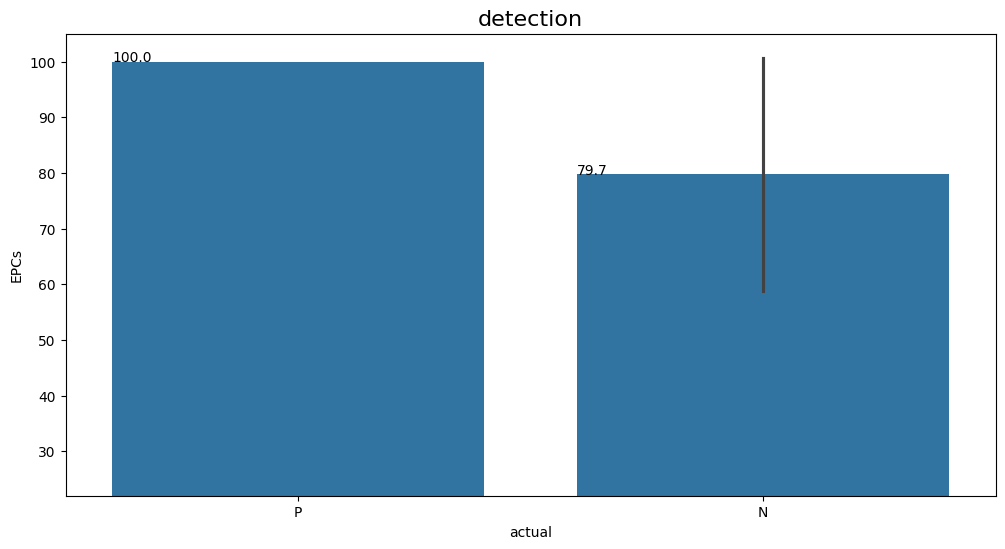

In [55]:
plt.figure(figsize=(12,6))

Bars = sns.barplot(data=EPCs, x='actual', y='EPCs', errorbar=('sd'), order=['P', 'N'])

for bar in Bars.patches:
    xvar=bar.get_x()
    yvar=bar.get_height()
    plt.annotate(f'{yvar:.1f}', (xvar, yvar))

val_min=EPCs['EPCs'].min()-5
val_max=EPCs['EPCs'].max()+5

plt.ylim([val_min, val_max])
plt.title('detection', size=16)

# make_ds, make_clf

In [56]:
def make_ds(tags_window, index_pivot, value, fill_value, columns_pivot, aggfunc_list, Xcols_ds_forced):
  # ds = pd.pivot_table(data=tags_window, index=index_pivot, columns=columns_pivot, aggfunc={'RSSI':aggfunc_list}, fill_value=0)
  ds = pd.pivot_table(data=tags_window, index=index_pivot, columns=columns_pivot, aggfunc={value:aggfunc_list}, fill_value=fill_value)
  Xcols_ds = ['_'.join([str(y) for y in x[1:]]) for x in ds.columns]
  ds.columns = Xcols_ds
  ds = ds.reindex(Xcols_ds_forced, axis=1, fill_value=fill_value)
  ds = ds.reset_index(drop=False)
  return ds

In [57]:
def make_clf(name, clf, ds, Xcols_ds_forced, window, columns_pivot, aggfunc_list):
  X = ds.loc[:, Xcols_ds_forced]
  y = ds.loc[:, 'actual']

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  accuracy = (y_test==y_pred).mean()
  print(name, accuracy)
  clf.window = window
  clf.columns_pivot = columns_pivot
  clf.aggfunc_list = aggfunc_list
  clf.Xcols_ds_forced = Xcols_ds_forced
  filename = f'{name}.pkl'
  with open(filename, 'wb') as f:
    pickle.dump(clf, f)
  return filename, clf

# ds_EPC_NEW

## window

In [79]:

window=11 # best for EPC prediction with (Antenna_coverage, slot_id_norm): both senses: 99.45, sense=0: 99.86, sense=1: 99.43
# window=9 # best for EPC prediction with (Antenna_coverage, slot_id_norm): both senses: 99.19, sense=0: 99.83, sense=1: 99.24
# window=5 # best for gpio prediction with (Antenna_coverage) both senses: 98.62
# window=5 # EPC prediction with (Antenna_coverage, slot_id_norm): both senses: 98.95, sense=0: 99.39 , sense=1: 99.25

#centered around gpio
Slots_id_crossing = range(-int(window/2), +int(window/2)+1)

# # centered around -1
# Slots_id_crossing = range(-int(window/2)-1, +int(window/2))

tags_crossing = tags [ tags['slot_id_norm'].isin(Slots_id_crossing)  ].reset_index(drop=True)
tags_nocrossing = tags [ ~tags['slot_id_norm'].isin(Slots_id_crossing)  ].reset_index(drop=True)
tags_crossing.shape, tags_nocrossing.shape, tags.shape

((65624, 18), (14228, 18), (79852, 18))

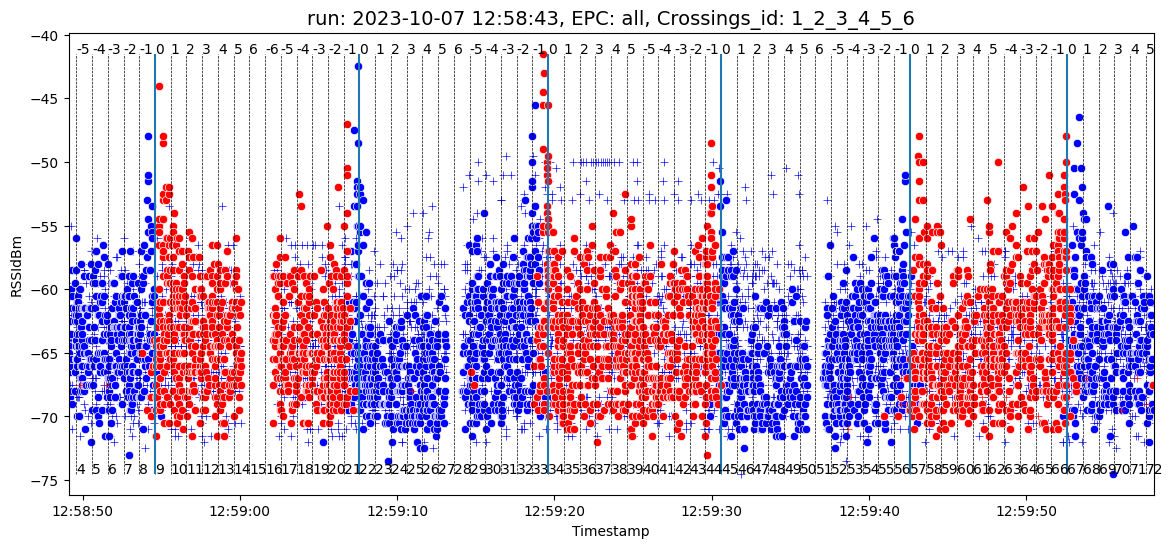

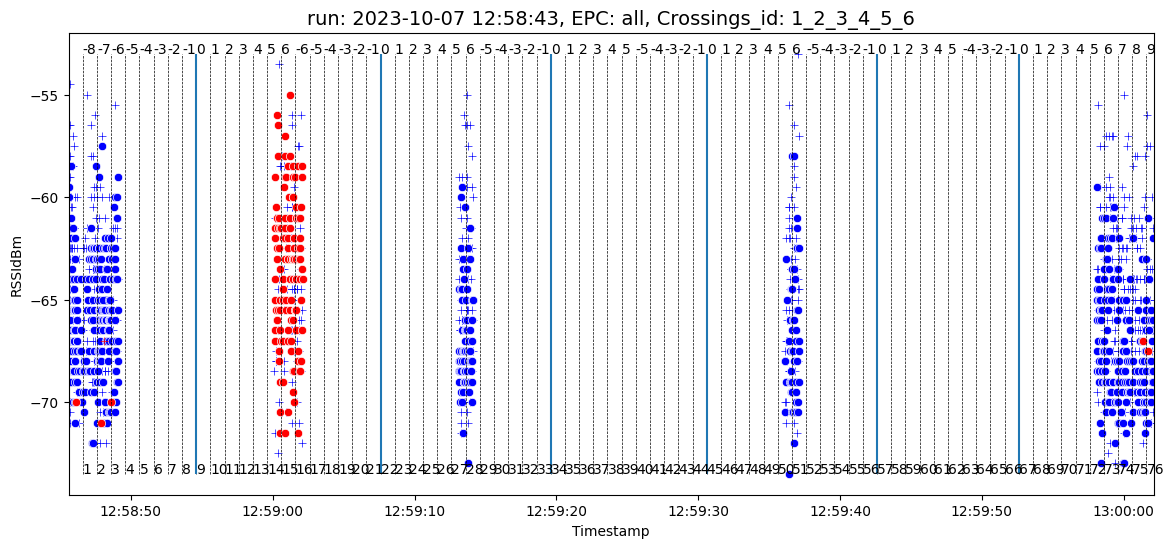

In [80]:

for run in tags['run'].unique()[:1]  :
    tags_crossing_run = tags_crossing [ tags_crossing['run']==run ]
    visu(tags_crossing_run, 'all', True, False)
    tags_nocrossing_run = tags_nocrossing [ tags_nocrossing['run']==run ]
    visu(tags_nocrossing_run, 'all', True, False)

## sense choice: 0:out>in ... 1:in>out

In [81]:
# Senses = [0, 1]
# Senses = [0]
Senses = [1]
tags_crossing = tags_crossing [tags_crossing['sense'].isin(Senses)]
# tags_nocrossing = tags_nocrossing [tags_nocrossing['sense'].isin(Senses)]
tags_crossing.shape, tags_nocrossing.shape

((33303, 18), (14228, 18))

In [82]:
tags_crossing['EPC'].nunique()

200

In [83]:
tags_nocrossing.sort_values('Timestamp').head()

,run,Timestamp,EPC,Antenna,RSSI,RSSIdBm,actual,actual_id,size,Antenna_coverage,slot_id,slotStart,crossing_id,slot_crossing,nocrossing_id,slot_crossing_next,slot_id_norm,sense
0,2023-10-07 12:58:43,2023-07-10 12:58:45.600410+02:00,AD3830770CCDD0AD383002AA,1,2.238721,-56.5,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0,-9,1
1,2023-10-07 12:58:43,2023-07-10 12:58:45.603587+02:00,AD3830770CCDD0AD38300333,1,0.562341,-62.5,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0,-9,1
2,2023-10-07 12:58:43,2023-07-10 12:58:45.609316+02:00,AD3830770CCDD0AD38300337,1,1.584893,-58.0,N,2,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0,-9,1
3,2023-10-07 12:58:43,2023-07-10 12:58:45.613458+02:00,AD3830770CCDD0AD383002DC,1,0.446684,-63.5,P,1,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0,-9,1
4,2023-10-07 12:58:43,2023-07-10 12:58:45.616716+02:00,AD3830770CCDD0AD3830020E,1,0.446684,-63.5,P,1,15,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0,-9,1


## Xcols_ds_forced

In [84]:
# columns_pivot=[]
# columns_pivot=['slot_id_norm']
# columns_pivot=['Antenna_coverage']
# columns_pivot=['Antenna', 'slot_id_norm']
columns_pivot=['Antenna_coverage', 'slot_id_norm']

# value='RSSIdBm'
# fill_value=-80
value='RSSI'
fill_value=0

# aggfunc_list=[sum, len, max, min]
aggfunc_list=[max]

aggfunc_dict = {x.__name__: x for x in aggfunc_list}
aggfunc_list = [aggfunc_dict[x] for x in sorted(aggfunc_dict.keys())]
list_all = [[x.__name__ for x in aggfunc_list]]
for feature in columns_pivot:
  Features_unique=sorted(tags_crossing[feature].unique())
  list_all.append(Features_unique)
Xcols_ds_forced = ['_'.join([str(y) for y in x]) for x in product(*list_all)]



In [85]:
len(Xcols_ds_forced)

22

In [86]:
print(Xcols_ds_forced)

['max_in_-5', 'max_in_-4', 'max_in_-3', 'max_in_-2', 'max_in_-1', 'max_in_0', 'max_in_1', 'max_in_2', 'max_in_3', 'max_in_4', 'max_in_5', 'max_out_-5', 'max_out_-4', 'max_out_-3', 'max_out_-2', 'max_out_-1', 'max_out_0', 'max_out_1', 'max_out_2', 'max_out_3', 'max_out_4', 'max_out_5']


## crossing

## Actuals_tags_artificial_error

In [87]:
# Actuals_artificial_errors = tags_artificial_errors.groupby('EPC')['actual'].first().reset_index(drop=False)
# Actuals_artificial_errors.head()

In [88]:
# Actuals = pd.concat([Actuals, Actuals_artificial_errors]).reset_index(drop=True)
# Actuals.shape

## ds_crossing

In [89]:
index_pivot = ['run', 'crossing_id', 'EPC']
ds_crossing = make_ds(tags_crossing, index_pivot, value, fill_value, columns_pivot, aggfunc_list, Xcols_ds_forced)
ds_crossing = pd.merge(ds_crossing, Actuals)
ds_crossing.head()

,run,crossing_id,EPC,max_in_-5,max_in_-4,max_in_-3,max_in_-2,max_in_-1,max_in_0,max_in_1,...,max_out_-1,max_out_0,max_out_1,max_out_2,max_out_3,max_out_4,max_out_5,actual,actual_id,size
0,2023-10-07 12:58:43,1,AD3830770CCDD0AD383001BD,0.000000,0.707946,0.000000,0.707946,0.794328,0.562341,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,2,15
1,2023-10-07 12:58:43,3,AD3830770CCDD0AD383001BD,0.000000,0.562341,0.000000,0.630957,0.446684,0.000000,0.630957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,2,15
2,2023-10-07 12:58:43,5,AD3830770CCDD0AD383001BD,0.000000,0.562341,0.891251,0.000000,1.000000,0.316228,0.794328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,2,15
3,2023-10-07 13:03:27,1,AD3830770CCDD0AD383001BD,0.112202,0.000000,0.177828,0.000000,0.199526,0.000000,0.199526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,2,15
4,2023-10-07 13:03:27,3,AD3830770CCDD0AD383001BD,0.063096,0.000000,0.000000,0.063096,0.089125,0.000000,0.199526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N,2,15


In [90]:
# universal id (for concat with ds_crossing)
ds_crossing = ds_crossing.rename(columns={'crossing_id':'id'})
ds_crossing['obs'] = 'crossing'
ds_crossing.head()

,run,id,EPC,max_in_-5,max_in_-4,max_in_-3,max_in_-2,max_in_-1,max_in_0,max_in_1,...,max_out_0,max_out_1,max_out_2,max_out_3,max_out_4,max_out_5,actual,actual_id,size,obs
0,2023-10-07 12:58:43,1,AD3830770CCDD0AD383001BD,0.000000,0.707946,0.000000,0.707946,0.794328,0.562341,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,N,2,15,crossing
1,2023-10-07 12:58:43,3,AD3830770CCDD0AD383001BD,0.000000,0.562341,0.000000,0.630957,0.446684,0.000000,0.630957,...,0.0,0.0,0.0,0.0,0.0,0.0,N,2,15,crossing
2,2023-10-07 12:58:43,5,AD3830770CCDD0AD383001BD,0.000000,0.562341,0.891251,0.000000,1.000000,0.316228,0.794328,...,0.0,0.0,0.0,0.0,0.0,0.0,N,2,15,crossing
3,2023-10-07 13:03:27,1,AD3830770CCDD0AD383001BD,0.112202,0.000000,0.177828,0.000000,0.199526,0.000000,0.199526,...,0.0,0.0,0.0,0.0,0.0,0.0,N,2,15,crossing
4,2023-10-07 13:03:27,3,AD3830770CCDD0AD383001BD,0.063096,0.000000,0.000000,0.063096,0.089125,0.000000,0.199526,...,0.0,0.0,0.0,0.0,0.0,0.0,N,2,15,crossing


In [91]:
(ds_crossing[Xcols_ds_forced].sum(axis=1)!=0).mean()

1.0

## nocrossing

In [92]:
# subnocrossing_id
def func_subnocrossing(x):
  slot_min=x['slot_id'].min()
  x['slot_id_nocrossing'] = x['slot_id'] - slot_min
  x['nocrossing_subid'] = x['slot_id_nocrossing'] // window
  x = x [ x['nocrossing_subid'] != x['nocrossing_subid'].max() ]
  return x
tags_nocrossing = tags_nocrossing.groupby(['run', 'nocrossing_id'], group_keys=False).apply(func_subnocrossing)

# slot_normalize
def func_slotnormalize(x):
  dict_slot_id=dict(zip(x['slot_id_nocrossing'].unique(), Slots_id_crossing))
  x['slot_id_norm'] = x['slot_id_nocrossing'].map(dict_slot_id)
  return x

tags_nocrossing = tags_nocrossing.groupby(['run', 'nocrossing_id', 'nocrossing_subid'], group_keys=False).apply(func_slotnormalize)

tags_nocrossing.head()

,run,Timestamp,EPC,Antenna,RSSI,RSSIdBm,actual,actual_id,size,Antenna_coverage,slot_id,slotStart,crossing_id,slot_crossing,nocrossing_id,slot_crossing_next,slot_id_norm,sense,slot_id_nocrossing,nocrossing_subid
3460,2023-10-07 13:08:43,2023-07-10 13:08:45.677447+02:00,AD3830770CCDD0AD383002C5,1,0.316228,-65.0,N,2,15,in,0,2023-07-10 13:08:45.677447+02:00,1,19,1,19.0,-5,1,0,0
3461,2023-10-07 13:08:43,2023-07-10 13:08:45.682288+02:00,AD3830770CCDD0AD383002D3,1,0.141254,-68.5,P,1,15,in,0,2023-07-10 13:08:45.677447+02:00,1,19,1,19.0,-5,1,0,0
3462,2023-10-07 13:08:43,2023-07-10 13:08:45.685469+02:00,AD3830770CCDD0AD383003B6,1,0.316228,-65.0,N,2,15,in,0,2023-07-10 13:08:45.677447+02:00,1,19,1,19.0,-5,1,0,0
3463,2023-10-07 13:08:43,2023-07-10 13:08:45.694432+02:00,AD3830770CCDD0AD383004B1,1,0.112202,-69.5,P,1,15,in,0,2023-07-10 13:08:45.677447+02:00,1,19,1,19.0,-5,1,0,0
3464,2023-10-07 13:08:43,2023-07-10 13:08:45.698729+02:00,AD3830770CCDD0AD3830035B,1,0.177828,-67.5,N,2,15,in,0,2023-07-10 13:08:45.677447+02:00,1,19,1,19.0,-5,1,0,0


In [93]:
# ds_nocrossing
index_pivot = ['run', 'nocrossing_id', 'nocrossing_subid', 'EPC']
ds_nocrossing = make_ds(tags_nocrossing, index_pivot, value, fill_value, columns_pivot, aggfunc_list, Xcols_ds_forced)
ds_nocrossing.head()

,run,nocrossing_id,nocrossing_subid,EPC,max_in_-5,max_in_-4,max_in_-3,max_in_-2,max_in_-1,max_in_0,...,max_out_-4,max_out_-3,max_out_-2,max_out_-1,max_out_0,max_out_1,max_out_2,max_out_3,max_out_4,max_out_5
0,2023-10-07 13:08:43,1,0,AD3830770CCDD0AD383001BF,0.100000,0.0,0.158489,0.223872,0.000000,0.158489,...,0,0,0,0,0,0,0,0,0,0
1,2023-10-07 13:08:43,1,0,AD3830770CCDD0AD383001C2,0.125893,0.0,0.089125,0.112202,0.079433,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,2023-10-07 13:08:43,1,0,AD3830770CCDD0AD383001C3,0.089125,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,2023-10-07 13:08:43,1,0,AD3830770CCDD0AD383001C8,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,2023-10-07 13:08:43,1,0,AD3830770CCDD0AD383001C9,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [94]:
# Actuals
ds_nocrossing['actual'] = 'N'

# universal id (for concat with ds_crossing)
ds_nocrossing['id'] = ds_nocrossing [['nocrossing_id', 'nocrossing_subid']].apply(lambda x:'_'.join([str(y) for y in x]), axis=1)
ds_nocrossing['obs'] = 'no crossing'
ds_nocrossing.head()

,run,nocrossing_id,nocrossing_subid,EPC,max_in_-5,max_in_-4,max_in_-3,max_in_-2,max_in_-1,max_in_0,...,max_out_-1,max_out_0,max_out_1,max_out_2,max_out_3,max_out_4,max_out_5,actual,id,obs
0,2023-10-07 13:08:43,1,0,AD3830770CCDD0AD383001BF,0.100000,0.0,0.158489,0.223872,0.000000,0.158489,...,0,0,0,0,0,0,0,N,1_0,no crossing
1,2023-10-07 13:08:43,1,0,AD3830770CCDD0AD383001C2,0.125893,0.0,0.089125,0.112202,0.079433,0.000000,...,0,0,0,0,0,0,0,N,1_0,no crossing
2,2023-10-07 13:08:43,1,0,AD3830770CCDD0AD383001C3,0.089125,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,N,1_0,no crossing
3,2023-10-07 13:08:43,1,0,AD3830770CCDD0AD383001C8,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,N,1_0,no crossing
4,2023-10-07 13:08:43,1,0,AD3830770CCDD0AD383001C9,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,N,1_0,no crossing


In [95]:
(ds_nocrossing[Xcols_ds_forced].sum(axis=1)!=0).mean()

1.0

In [96]:
ds_crossing.shape, ds_nocrossing.shape

((5254, 29), (140, 29))

## ds

In [97]:
ds = pd.concat([\
           ds_crossing [['run', 'id', 'EPC', 'obs', 'actual'] + Xcols_ds_forced],\
           ds_nocrossing [['run', 'id', 'EPC', 'obs', 'actual'] + Xcols_ds_forced]], axis=0)
ds = ds.reset_index(drop=True)
ds.head()

,run,id,EPC,obs,actual,max_in_-5,max_in_-4,max_in_-3,max_in_-2,max_in_-1,...,max_out_-4,max_out_-3,max_out_-2,max_out_-1,max_out_0,max_out_1,max_out_2,max_out_3,max_out_4,max_out_5
0,2023-10-07 12:58:43,1,AD3830770CCDD0AD383001BD,crossing,N,0.000000,0.707946,0.000000,0.707946,0.794328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-10-07 12:58:43,3,AD3830770CCDD0AD383001BD,crossing,N,0.000000,0.562341,0.000000,0.630957,0.446684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-10-07 12:58:43,5,AD3830770CCDD0AD383001BD,crossing,N,0.000000,0.562341,0.891251,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-10-07 13:03:27,1,AD3830770CCDD0AD383001BD,crossing,N,0.112202,0.000000,0.177828,0.000000,0.199526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-10-07 13:03:27,3,AD3830770CCDD0AD383001BD,crossing,N,0.063096,0.000000,0.000000,0.063096,0.089125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
ds.groupby('obs').size()

obs
crossing       5254
no crossing     140
dtype: int64

## rf

In [99]:
rf = RandomForestClassifier()

Accuracies=[]
Errors = pd.DataFrame()
for shuffle_id in range(10):
  ds_shuffle = ds.sample(frac=1, random_state=shuffle_id)
  for ds_test in np.array_split(ds_shuffle, 5):
    idx_test = ds_test.index
    idx_train = [x for x in ds_shuffle.index if x not in idx_test]
    ds_train = ds_shuffle.loc[idx_train]
    X_train = ds_train.loc[:, Xcols_ds_forced]
    y_train = ds_train.loc[:, 'actual']
    X_test = ds_test.loc[:, Xcols_ds_forced]
    y_test = ds_test.loc[:, 'actual']
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    ds_shuffle.loc[idx_test, 'pred'] = y_pred
  accuracy = (ds_shuffle['actual']==ds_shuffle['pred']).mean()
  print(accuracy)
  Accuracies.append(accuracy)
  Errors_shuffle_id = ds_shuffle [ds_shuffle['actual'] != ds_shuffle['pred']]
  Errors = pd.concat([Errors, Errors_shuffle_id], axis=0)
pd.Series(Accuracies).describe()

0.9948090470893586
0.9944382647385984
0.9936967000370782
0.9944382647385984
0.9948090470893586
0.9942528735632183
0.9944382647385984
0.9946236559139785
0.9942528735632183
0.9940674823878384


count    10.000000
mean      0.994383
std       0.000339
min       0.993697
25%       0.994253
50%       0.994438
75%       0.994577
max       0.994809
dtype: float64

## clf pickle

In [751]:
clf = RandomForestClassifier()
name = 'clf_EPC_gpio'

filename, clf = make_clf(name, clf, ds, Xcols_ds_forced, window, columns_pivot, aggfunc_list)

clf_EPC_gpio 0.9919177075679647


In [ ]:
# clf = RandomForestClassifier()
# name = 'clf_EPC'

# filename, clf = make_clf(name, clf, ds, Xcols_ds_forced, window, columns_pivot, aggfunc_list)

## Convolution ismin workshop 2024

In [ ]:
set_random_seed(42)

In [ ]:
Accuracies=[]
Errors = pd.DataFrame()

ds['actual_conv'] = ds['actual'].map({'P':1, 'N':0})

for shuffle_id in range(10):
  ds_shuffle = ds.sample(frac=1)
  for ds_test in np.array_split(ds_shuffle, 5):
    idx_test = ds_test.index
    idx_train = [x for x in ds_shuffle.index if x not in idx_test]
    ds_train = ds_shuffle.loc[idx_train]
    X_train = ds_train.loc[:, Xcols_ds_forced]
    y_train = ds_train.loc[:, 'actual_conv']
    X_test = ds_test.loc[:, Xcols_ds_forced]
    y_test = ds_test.loc[:, 'actual_conv']

    input1 = Input(shape=(len(Xcols_ds_forced),1))
    layer1 = Conv1D(filters=64, kernel_size=2, activation='relu')(input1)
    layer2 = Conv1D(filters=64, kernel_size=2, activation='relu')(layer1)
    layer3 = Dropout(0.5)(layer2)
    layer4 = MaxPooling1D(pool_size=2)(layer3)
    layer5 = Flatten()(layer4)
    layer6 = Dense(100, activation='relu') (layer5)

    out = Dense(1, activation='sigmoid') (layer6)

    optimizer = Adam(learning_rate=0.001)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)
    filepath='best_epoch.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping], verbose=1 )

    y_pred = model.predict(X_test)
    # rf.fit(X_train, y_train)
    # y_pred = rf.predict(X_test)
    ds_shuffle.loc[idx_test, 'pred'] = y_pred
  ds_shuffle['pred'] = np.round(ds_shuffle['pred'])
  accuracy = (ds_shuffle['actual_conv']==ds_shuffle['pred']).mean()
  print(accuracy)
  Accuracies.append(accuracy)
  Errors_shuffle_id = ds_shuffle [ds_shuffle['actual_conv'] != ds_shuffle['pred']]
  Errors = pd.concat([Errors, Errors_shuffle_id], axis=0)
pd.Series(Accuracies).describe()

Epoch 1/1000
23/45 [==============>...............] - ETA: 0s - loss: 0.5764 - accuracy: 0.7507

KeyboardInterrupt: 

## errors

In [ ]:
Errors = Errors.groupby(['run', 'EPC', 'id', 'obs']).size().rename('Q_error').sort_values(ascending=False).reset_index(drop=False)
Errors = pd.merge(Errors, Actuals).sort_values('Q_error', ascending=False).reset_index(drop=True)
Errors

,run,EPC,id,obs,Q_error,actual,z,size
0,2024-03-27 16:05:26,AD3830770CCDD0AD383001D5,2_0,no crossing,10,N,0.8,15
1,2024-03-27 16:14:09,AD3830770CCDD0AD38300450,5,crossing,10,P,0.2,15
2,2024-03-27 16:24:39,AD3830770CCDD0AD383003BC,3,crossing,10,P,0.4,15
3,2024-03-27 16:05:26,AD3830770CCDD0AD383003E6,5,crossing,10,P,1,15
4,2024-03-27 16:14:09,AD3830770CCDD0AD38300205,5,crossing,10,P,0.2,15
5,2024-03-27 16:05:26,AD3830770CCDD0AD3830040B,5,crossing,10,P,2,15
6,2024-03-27 16:05:26,AD3830770CCDD0AD383002E0,5,crossing,10,N,2,15
7,2024-03-27 16:05:26,AD3830770CCDD0AD383002E0,3,crossing,10,N,2,15
8,2024-03-27 16:05:26,AD3830770CCDD0AD383002A0,1,crossing,10,N,1.2,15
9,2024-03-27 16:24:39,AD3830770CCDD0AD383001C9,3,crossing,9,P,1.8,15


In [ ]:
Errors = Errors [Errors['Q_error']==10].reset_index(drop=True)
Errors['status']='error'
len(Errors)

9

In [ ]:
Errors['clf']='rf'

In [ ]:
Errors.groupby('actual').size()

actual
N    4
P    5
dtype: int64

In [ ]:
Errors.groupby(['obs']).size()

obs
crossing       8
no crossing    1
dtype: int64

In [ ]:
Errors.groupby(['obs', 'actual']).size()

obs          actual
crossing     N         3
             P         5
no crossing  N         1
dtype: int64

In [ ]:
Errors.groupby('run').size()

run
2024-03-27 16:05:26    6
2024-03-27 16:14:09    2
2024-03-27 16:24:39    1
dtype: int64

In [ ]:
Runs

,actualDyn,speed,antCov,antGain,antTilt,antLoc,antSep,site,run,ReaderName,AntennaIDs,InventoryMode,ModeIndex,Population,PowerInDbm,Session
0,"[[P,0,0.5,-3.5,curved,2],[N,2,0.5,0.5,none,2]]",1,1in2in3out4out,8dBiC,45,floor,1,tagsys,2024-03-27 16:05:26,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
1,"[[P,0,1.5,-3.5,curved,2],[N,2,1.5,1.5,none,2]]",1,1in2in3out4out,8dBiC,45,floor,1,tagsys,2024-03-27 16:14:09,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
2,"[[P,0,2.5,-3.5,curved,2],[N,2,2.5,2.5,none,2]]",1,1in2in3out4out,8dBiC,45,floor,1,tagsys,2024-03-27 16:24:39,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1
3,"[[P,0,3.5,-3.5,curved,2],[N,2,3.5,3.5,none,2]]",1,1in2in3out4out,8dBiC,45,floor,1,tagsys,2024-03-27 16:29:49,169.254.1.1,"1,2,3,4",SingleTarget,5,32,25,1


## visu errors

In [ ]:
for i, row in Errors.iterrows():
  run=row['run']
  id=row['id']
  EPC=row['EPC']
  obs=row['obs']
  Q_error=row['Q_error']
  print(run, id, obs)
  tags_run = tags [ tags['run']==run ]
  if obs == 'crossing':
    tags_id = tags_run [ tags_run['crossing_id']==id ]
  if obs == 'no crossing':
    nocrossing_id = int(id.split('_')[0])
    nocrossing_subid = int(id.split('_')[1])
    print(nocrossing_id, nocrossing_subid)
    Slots_nocrossing = tags_nocrossing [ (tags_nocrossing['run']==run) & (tags_nocrossing['nocrossing_id']==nocrossing_id) & (tags_nocrossing['nocrossing_subid']==nocrossing_subid) ]['slot_id'].unique()
    print(Slots_nocrossing)
    tags_id = tags_run [ tags_run['slot_id'].isin(Slots_nocrossing) ]

  Runs_run = Runs [ Runs['run']==run ]
  print(Runs_run['actualDyn'])
  visu(tags_run, 'all', True, False)
  visu(tags_run, EPC, True, False)
  visu(tags_id, EPC, True, False)

Output hidden; open in https://colab.research.google.com to view.

## DecisionBoundaryDisplay if 2 features

In [ ]:
X = ds.loc[:, Xcols_ds_forced]
y = ds.loc[:, 'actual']

In [ ]:
clf=SVC(kernel='rbf')
# clf=SVC(kernel='linear')
# clf = SVC(kernel='poly', C=10)
name='_'
make_clf(name, clf, ds, Xcols_ds_forced, window, columns_pivot, aggfunc_list)

In [ ]:
# DecisionBoundaryDisplay.from_estimator(clf, X, response_method="predict")
# DecisionBoundaryDisplay.from_estimator(clf, X, response_method="predict", alpha=0.5)
DecisionBoundaryDisplay.from_estimator(clf, X, response_method="predict", plot_method='contour')
# DecisionBoundaryDisplay.from_estimator(clf, X, response_method="decision_function", plot_method='contour')
# DecisionBoundaryDisplay.from_estimator(clf, X, response_method="decision_function", plot_method='contour', levels=[0])

sns.scatterplot(data=ds, x='max_in', y='max_out', hue='actual')

## artificial errors window=11, (max_in, max_out)

In [ ]:
Errors

,run,EPC,id,obs,Q_error,actual,status,clf
0,2023-10-07 12:58:43,AD3830770CCDD0AD383001BE,1,crossing,10,N,error,rf
1,2023-10-07 13:14:00,AD3830770CCDD0AD38300372,3,crossing,10,N,error,rf
2,2023-10-07 13:08:43,AD3830770CCDD0AD38300476,5,crossing,10,P,error,rf
3,2023-10-07 14:52:02,AD3830770CCDD0AD38300314,5,crossing,10,N,error,rf
4,2023-10-07 14:01:18,AD3830770CCDD0AD38300214,5,crossing,10,P,error,rf
5,2023-10-07 13:03:27,AD3830770CCDD0AD3830036A,1,crossing,10,N,error,rf
6,2023-10-07 13:51:05,AD3830770CCDD0AD383002AA,3,crossing,10,N,error,rf
7,2023-10-07 13:47:12,AD3830770CCDD0AD383002E0,3,crossing,10,N,error,rf
8,2023-10-07 12:58:43,AD3830770CCDD0AD3830028A,5,crossing,10,P,error,rf
9,2023-10-07 13:47:12,AD3830770CCDD0AD3830028A,1,crossing,10,P,error,rf


In [ ]:
tags[:1]

,run,Timestamp,EPC,Antenna,RSSI,RSSIdBm,actual,Antenna_coverage,slot_id,slotStart,crossing_id,slot_crossing,nocrossing_id,slot_crossing_next,slot_id_norm,sense
0,2023-10-07 12:58:43,2023-07-10 12:58:45.600410+02:00,AD3830770CCDD0AD383002AA,1,2.238721,-56.5,N,in,0,2023-07-10 12:58:45.600410+02:00,1,9,1,9.0,-9,1


In [ ]:
tags_error = pd.merge(tags_crossing, Errors[Errors['obs']=='crossing'].drop(columns=['actual']).rename(columns={'id':'crossing_id'}), on=['run', 'crossing_id', 'EPC'], how='inner')
tags_error = tags_error[['run', 'crossing_id', 'Timestamp', 'EPC', 'Antenna', 'RSSI', 'RSSIdBm', 'actual' ]]
tags_error

,run,crossing_id,Timestamp,EPC,Antenna,RSSI,RSSIdBm,actual
0,2023-10-07 12:58:43,1,2023-07-10 12:58:49.839603+02:00,AD3830770CCDD0AD383001BE,3,0.177828,-67.5,N
1,2023-10-07 12:58:43,1,2023-07-10 12:58:51.463181+02:00,AD3830770CCDD0AD383001BE,3,0.177828,-67.5,N
2,2023-10-07 12:58:43,1,2023-07-10 12:58:55.796116+02:00,AD3830770CCDD0AD383001BE,3,0.158489,-68.0,N
3,2023-10-07 12:58:43,3,2023-07-10 12:59:15.394116+02:00,AD3830770CCDD0AD383003ED,2,0.199526,-67.0,P
4,2023-10-07 12:58:43,3,2023-07-10 12:59:16.962485+02:00,AD3830770CCDD0AD383003ED,2,0.251189,-66.0,P
5,2023-10-07 12:58:43,3,2023-07-10 12:59:18.492503+02:00,AD3830770CCDD0AD383003ED,2,0.158489,-68.0,P
6,2023-10-07 12:58:43,5,2023-07-10 12:59:37.552791+02:00,AD3830770CCDD0AD3830028A,2,0.251189,-66.0,P
7,2023-10-07 12:58:43,5,2023-07-10 12:59:38.168710+02:00,AD3830770CCDD0AD3830028A,2,0.177828,-67.5,P
8,2023-10-07 12:58:43,5,2023-07-10 12:59:41.536182+02:00,AD3830770CCDD0AD3830028A,1,0.112202,-69.5,P
9,2023-10-07 12:58:43,5,2023-07-10 12:59:42.105650+02:00,AD3830770CCDD0AD3830028A,1,0.125893,-69.0,P


In [ ]:
def artificial_err_func(x):

  EPC=x['EPC'].values[0]
  x_out=pd.DataFrame()
  for i in range(n_artificial):
    y = x.copy()
    EPC_artificial = f'{EPC}_{i}'
    y['EPC'] = EPC_artificial
    ts_noise = pd.to_timedelta( np.random.normal(mu_ts, sigma_ts, len(y)), unit='sec' )
    y['Timestamp'] = y['Timestamp'] + ts_noise
    rssidB_noise = np.random.normal(mu_rssi, sigma_rssi, len(y))
    y['RSSI'] = y['RSSI'] *  np.power(10, rssidB_noise/10)
    y['RSSIdBm'] = y['RSSIdBm'] + rssidB_noise
    x_out = pd.concat([x_out, y], axis=0)
  return x_out

n_artificial=10
mu_ts, sigma_ts = 0, 1
mu_rssi, sigma_rssi = 0, 1
tags_artificial_errors = tags_error.groupby(['run', 'crossing_id', 'EPC']).apply(artificial_err_func).reset_index(drop=True).drop(columns=['crossing_id'])
tags_artificial_errors

,run,Timestamp,EPC,Antenna,RSSI,RSSIdBm,actual
0,2023-10-07 12:58:43,2023-07-10 12:58:49.884624930+02:00,AD3830770CCDD0AD383001BE_0,3,0.180701,-67.430395,N
1,2023-10-07 12:58:43,2023-07-10 12:58:51.470893147+02:00,AD3830770CCDD0AD383001BE_0,3,0.170834,-67.674254,N
2,2023-10-07 12:58:43,2023-07-10 12:58:55.807166587+02:00,AD3830770CCDD0AD383001BE_0,3,0.156778,-68.047144,N
3,2023-10-07 12:58:43,2023-07-10 12:58:49.986479292+02:00,AD3830770CCDD0AD383001BE_1,3,0.172544,-67.631010,N
4,2023-10-07 12:58:43,2023-07-10 12:58:51.458234053+02:00,AD3830770CCDD0AD383001BE_1,3,0.181957,-67.400312,N
...,...,...,...,...,...,...,...
585,2023-10-07 14:52:02,2023-07-10 14:53:01.364292507+02:00,AD3830770CCDD0AD38300314_7,2,0.625169,-62.040024,N
586,2023-10-07 14:52:02,2023-07-10 14:53:00.189395445+02:00,AD3830770CCDD0AD38300314_8,1,0.201420,-66.958964,N
587,2023-10-07 14:52:02,2023-07-10 14:53:01.513004374+02:00,AD3830770CCDD0AD38300314_8,2,0.634373,-61.976553,N
588,2023-10-07 14:52:02,2023-07-10 14:53:00.217072764+02:00,AD3830770CCDD0AD38300314_9,1,0.202478,-66.936213,N


## single P detection

In [ ]:
Q_detections = tags.groupby(['run', 'crossing_id', 'actual', 'EPC']).size().rename('detections').reset_index(drop=False)
Q_detections_single = Q_detections.groupby(['actual', Q_detections['detections']==1]).size().rename('Q').reset_index(drop=False).rename(columns={'detections':'Q detections=1'})
Q_detections_single

,actual,Q detections=1,Q
0,N,False,1551
1,N,True,241
2,P,False,2400


Text(0.5, 1.0, 'detections per EPC (per crossing)')

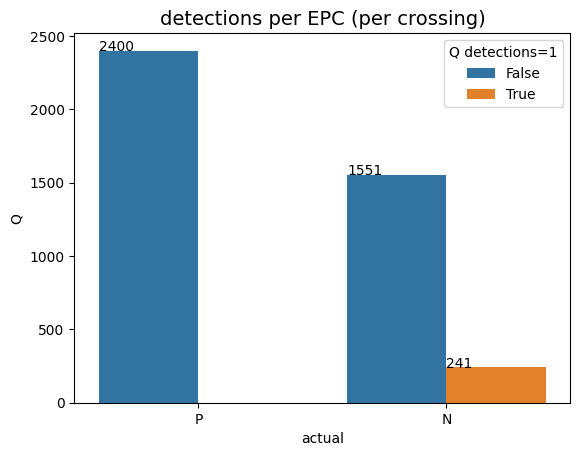

In [ ]:
Bars = sns.barplot(data=Q_detections_single, x='actual', y='Q', hue='Q detections=1', order=['P', 'N'])
for bar in Bars.patches[:-2]:
  xvar=bar.get_x()
  yvar=bar.get_height()
  plt.annotate(f'{yvar:.0f}', (xvar, yvar))
plt.title('detections per EPC (per crossing)', size=14)

In [ ]:
Errors

,run,EPC,id,obs,Q_error,actual,z,size,status,clf
0,2024-03-27 16:05:26,AD3830770CCDD0AD383001D5,2_0,no crossing,10,N,0.8,15,error,rf
1,2024-03-27 16:14:09,AD3830770CCDD0AD38300450,5,crossing,10,P,0.2,15,error,rf
2,2024-03-27 16:24:39,AD3830770CCDD0AD383003BC,3,crossing,10,P,0.4,15,error,rf
3,2024-03-27 16:05:26,AD3830770CCDD0AD383003E6,5,crossing,10,P,1,15,error,rf
4,2024-03-27 16:14:09,AD3830770CCDD0AD38300205,5,crossing,10,P,0.2,15,error,rf
5,2024-03-27 16:05:26,AD3830770CCDD0AD3830040B,5,crossing,10,P,2,15,error,rf
6,2024-03-27 16:05:26,AD3830770CCDD0AD383002E0,5,crossing,10,N,2,15,error,rf
7,2024-03-27 16:05:26,AD3830770CCDD0AD383002E0,3,crossing,10,N,2,15,error,rf
8,2024-03-27 16:05:26,AD3830770CCDD0AD383002A0,1,crossing,10,N,1.2,15,error,rf


In [ ]:
Errors = pd.merge(Errors [Errors['obs']=='crossing'].rename(columns={'id':'crossing_id'}), Q_detections.drop(columns=['actual']), on=['run', 'crossing_id', 'EPC'], how='left')
Errors.head()

,run,EPC,crossing_id,obs,Q_error,actual,z,size,status,clf,detections
0,2024-03-27 16:14:09,AD3830770CCDD0AD38300450,5,crossing,10,P,0.2,15,error,rf,6
1,2024-03-27 16:24:39,AD3830770CCDD0AD383003BC,3,crossing,10,P,0.4,15,error,rf,4
2,2024-03-27 16:05:26,AD3830770CCDD0AD383003E6,5,crossing,10,P,1,15,error,rf,6
3,2024-03-27 16:14:09,AD3830770CCDD0AD38300205,5,crossing,10,P,0.2,15,error,rf,6
4,2024-03-27 16:05:26,AD3830770CCDD0AD3830040B,5,crossing,10,P,2,15,error,rf,14


In [ ]:
Errors_single = Errors .groupby(['actual', (Errors['detections']==1)]).size().rename('Q')\
                    .reset_index(drop=False).rename(columns={'detections':'Q detections=1'})
Errors_single

,actual,Q detections=1,Q
0,N,False,3
1,P,False,5


Text(0.5, 1.0, 'detections per EPC in error  (per crossing)')

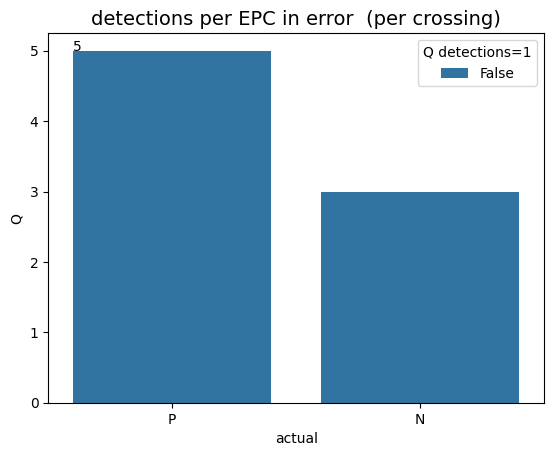

In [ ]:
Bars = sns.barplot(data=Errors_single, x='actual', y='Q', hue='Q detections=1', order=['P', 'N'])
for bar in Bars.patches[:-2]:
  xvar=bar.get_x()
  yvar=bar.get_height()
  plt.annotate(f'{yvar:.0f}', (xvar, yvar))
plt.title('detections per EPC in error  (per crossing)', size=14)

In [ ]:
ds.shape

(3650, 27)

## confusion matrix

In [ ]:
ds[:1]

,run,id,EPC,obs,actual,max_in_-5,max_in_-4,max_in_-3,max_in_-2,max_in_-1,...,max_out_-4,max_out_-3,max_out_-2,max_out_-1,max_out_0,max_out_1,max_out_2,max_out_3,max_out_4,max_out_5
0,2024-03-27 16:05:26,1,AD3830770CCDD0AD383001BD,crossing,N,4.466836,0.0,3.162278,4.466836,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
Errors[:1]

,run,EPC,crossing_id,obs,Q_error,actual,z,size,status,clf,detections
0,2024-03-27 16:14:09,AD3830770CCDD0AD38300450,5,crossing,10,P,0.2,15,error,rf,6


In [ ]:
ds = pd.merge(ds, Errors.drop(columns=['actual']), left_on=['run', 'EPC', 'id'], right_on=['run', 'EPC', 'crossing_id'], how='outer')
ds['status'] = ds['status'].fillna('no error')
ds

,run,id,EPC,obs_x,actual,max_in_-5,max_in_-4,max_in_-3,max_in_-2,max_in_-1,...,max_out_4,max_out_5,crossing_id,obs_y,Q_error,z,size,status,clf,detections
0,2024-03-27 16:05:26,1,AD3830770CCDD0AD383001BD,crossing,N,4.466836,0.000000,3.162278,4.466836,0.000000,...,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN
1,2024-03-27 16:05:26,3,AD3830770CCDD0AD383001BD,crossing,N,0.000000,0.112202,0.125893,0.000000,0.223872,...,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN
2,2024-03-27 16:05:26,5,AD3830770CCDD0AD383001BD,crossing,N,0.000000,0.223872,0.199526,0.000000,0.223872,...,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN
3,2024-03-27 16:14:09,1,AD3830770CCDD0AD383001BD,crossing,N,1.995262,0.000000,1.778279,0.000000,1.000000,...,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN
4,2024-03-27 16:14:09,3,AD3830770CCDD0AD383001BD,crossing,N,0.000000,0.707946,0.630957,0.891251,0.000000,...,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,2024-03-27 16:29:49,6_0,AD3830770CCDD0AD383004A5,no crossing,N,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN
3646,2024-03-27 16:29:49,6_0,AD3830770CCDD0AD383004AA,no crossing,N,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.158489,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN
3647,2024-03-27 16:29:49,6_0,AD3830770CCDD0AD383004AF,no crossing,N,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN
3648,2024-03-27 16:29:49,6_0,AD3830770CCDD0AD383004B2,no crossing,N,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN


In [ ]:
FN_index = ds [(ds['status']=='error') & (ds['actual']=='P')].index
FP_index = ds [(ds['status']=='error') & (ds['actual']=='N')].index
T_index = ds[ds['status']=='no error'].index
ds.loc[FN_index, 'pred'] = 'N'
ds.loc[FP_index, 'pred'] = 'P'
ds.loc[T_index, 'pred'] = ds.loc[T_index, 'actual']
ds.head()

,run,id,EPC,obs_x,actual,max_in_-5,max_in_-4,max_in_-3,max_in_-2,max_in_-1,...,max_out_5,crossing_id,obs_y,Q_error,z,size,status,clf,detections,pred
0,2024-03-27 16:05:26,1,AD3830770CCDD0AD383001BD,crossing,N,4.466836,0.000000,3.162278,4.466836,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN,N
1,2024-03-27 16:05:26,3,AD3830770CCDD0AD383001BD,crossing,N,0.000000,0.112202,0.125893,0.000000,0.223872,...,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN,N
2,2024-03-27 16:05:26,5,AD3830770CCDD0AD383001BD,crossing,N,0.000000,0.223872,0.199526,0.000000,0.223872,...,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN,N
3,2024-03-27 16:14:09,1,AD3830770CCDD0AD383001BD,crossing,N,1.995262,0.000000,1.778279,0.000000,1.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN,N
4,2024-03-27 16:14:09,3,AD3830770CCDD0AD383001BD,crossing,N,0.000000,0.707946,0.630957,0.891251,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,no error,NaN,NaN,N


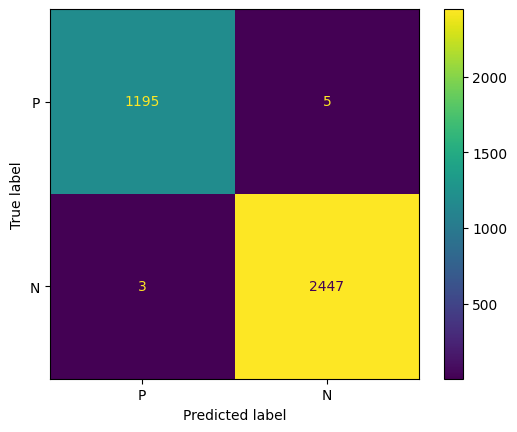

In [ ]:
ConfusionMatrixDisplay.from_predictions(ds['actual'], ds['pred'], values_format='d', labels=['P', 'N'])

## Antenna_coverage

In [ ]:
tags_Errors = pd.merge(tags, Errors.drop(columns=['actual']), on=['run', 'crossing_id', 'EPC'], how='left')
tags_Errors['status'] = tags_Errors['status'].fillna('no error')

In [ ]:
tags_Errors.groupby(['status', 'run', 'crossing_id', 'EPC', 'actual']) ['Antenna_coverage'].nunique().reset_index(drop=False).groupby(['status', 'actual'])['Antenna_coverage'].mean()

status    actual
error     N         2.0000
          P         1.6000
no error  N         1.0654
          P         2.0000
Name: Antenna_coverage, dtype: float64

In [ ]:
ds.groupby(['status', 'run', 'id', 'EPC', 'actual']) .size().rename('Q').reset_index(drop=False).groupby(['status', 'actual']) ['Q'].sum()

status    actual
error     N            3
          P            5
no error  N         2447
          P         1195
Name: Q, dtype: int64

In [ ]:
Qantcov = pd.concat([\
           tags_Errors.groupby(['status', 'run', 'crossing_id', 'EPC', 'actual']) ['Antenna_coverage'].nunique().reset_index(drop=False).groupby(['status', 'actual'])['Antenna_coverage'].mean(),\
           ds.groupby(['status', 'run', 'id', 'EPC', 'actual']) .size().rename('Q').reset_index(drop=False).groupby(['status', 'actual']) ['Q'].sum()
           ], axis=1).reset_index(drop=False)
Qantcov

,status,actual,Antenna_coverage,Q
0,error,N,2.0000,3
1,error,P,1.6000,5
2,no error,N,1.0654,2447
3,no error,P,2.0000,1195


Text(0.5, 1.0, 'EPCs in error')

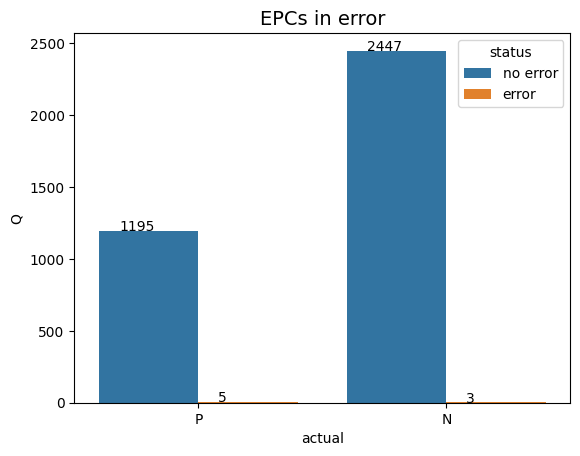

In [ ]:
Bars = sns.barplot(data=Qantcov, x='actual', y='Q', hue='status', order=['P', 'N'], hue_order=['no error', 'error'])
for bar in Bars.patches[:-2]:
  xvar=bar.get_x()
  yvar=bar.get_height()
  width=bar.get_width()
  plt.annotate(f'{yvar:.0f}', (xvar+width/5,yvar))
plt.title('EPCs in error', size=14)

Text(0.5, 1.0, 'unique Antenna_coverage')

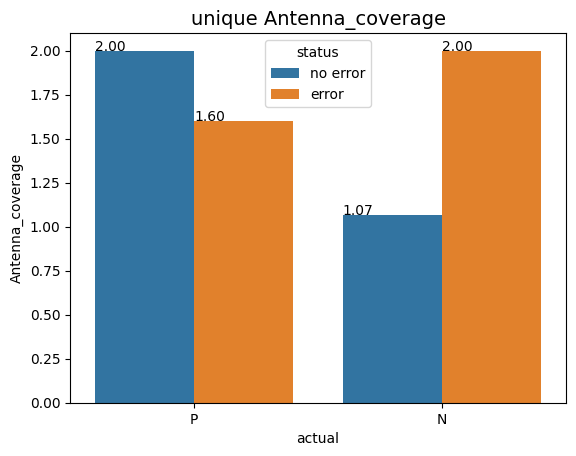

In [ ]:
Bars = sns.barplot(data=Qantcov, x='actual', y='Antenna_coverage', hue='status', order=['P', 'N'], hue_order=['no error', 'error'])
for bar in Bars.patches[:-2]:
  xvar=bar.get_x()
  yvar=bar.get_height()
  plt.annotate(f'{yvar:.2f}', (xvar,yvar))
plt.title('unique Antenna_coverage', size=14)

In [ ]:
Qantcov_long = pd.melt(Qantcov, id_vars=['status', 'actual'], value_vars=['Antenna_coverage', 'Q'])
Qantcov_long

,status,actual,variable,value
0,error,N,Antenna_coverage,2.0000
1,error,P,Antenna_coverage,1.6000
2,no error,N,Antenna_coverage,1.0654
3,no error,P,Antenna_coverage,2.0000
4,error,N,Q,3.0000
5,error,P,Q,5.0000
6,no error,N,Q,2447.0000
7,no error,P,Q,1195.0000


In [ ]:
Qantcov_long

,status,actual,variable,value
0,error,N,Antenna_coverage,2.0000
1,error,P,Antenna_coverage,1.6000
2,no error,N,Antenna_coverage,1.0654
3,no error,P,Antenna_coverage,2.0000
4,error,N,Q,3.0000
5,error,P,Q,5.0000
6,no error,N,Q,2447.0000
7,no error,P,Q,1195.0000


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)


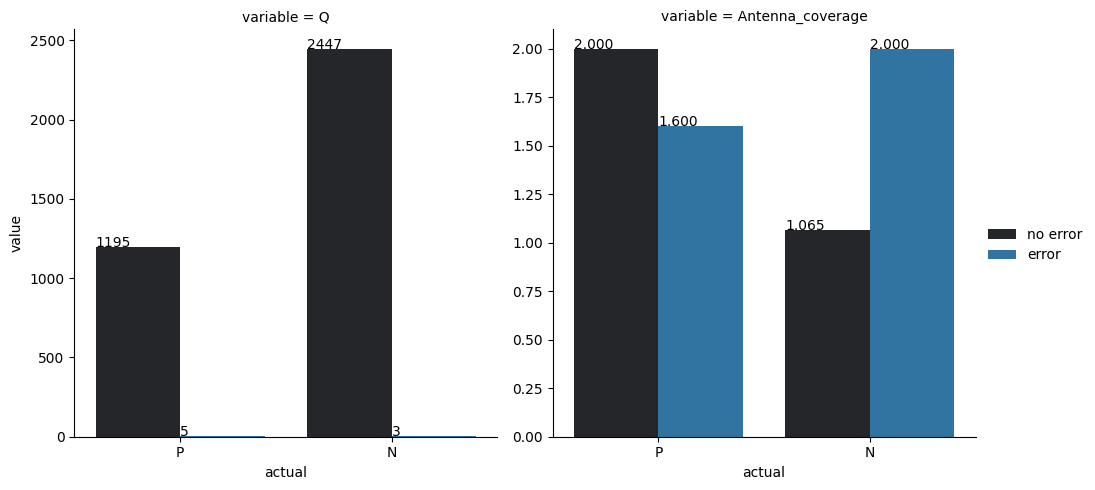

In [ ]:
g = sns.FacetGrid(data=Qantcov_long, col='variable', height=5, col_order=['Q', 'Antenna_coverage'], sharey=False) #, hue_kws={'color': ['red', 'blue']}
g.map_dataframe(sns.barplot, x='actual', y='value', order=['P','N'], hue='status', hue_order=['no error', 'error'])
for row_val, ax in g.axes_dict.items():
# for ax in g.axes.flatten():
  for bar in ax.patches[:-2]:
    xvar=bar.get_x()
    yvar=bar.get_height()
    if row_val=='Q':
      ax.annotate(f'{int(yvar)}', (xvar, yvar))
    if row_val=='Antenna_coverage':
      ax.annotate(f'{yvar:.3f}', (xvar, yvar))
g.add_legend()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)


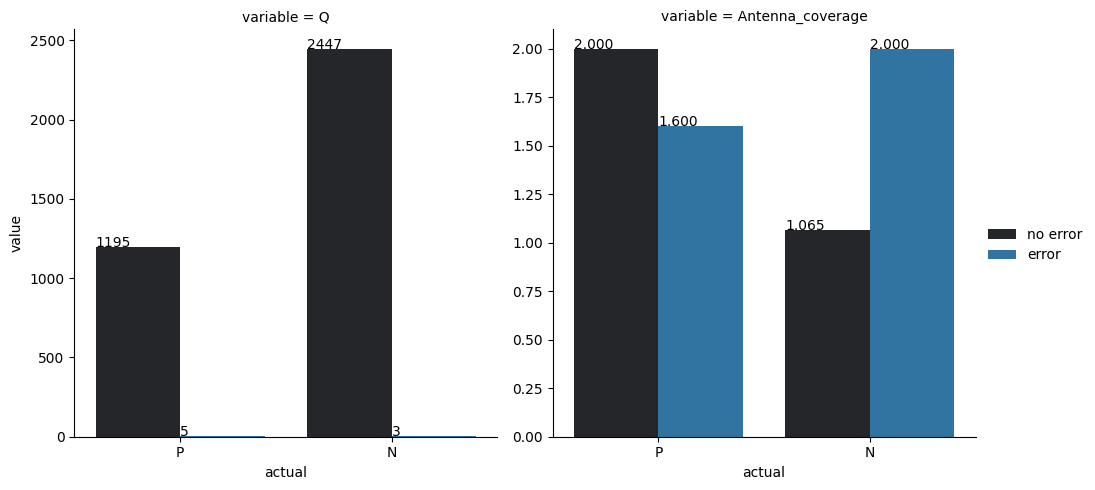

In [ ]:
g = sns.FacetGrid(data=Qantcov_long, col='variable', height=5, col_order=['Q', 'Antenna_coverage'], sharey=False)
g.map_dataframe(sns.barplot, x='actual', y='value', order=['P','N'], hue='status', hue_order=['no error', 'error'])
for row_val, ax in g.axes_dict.items():
# for ax in g.axes.flatten():
  for bar in ax.patches[:-2]:
    xvar=bar.get_x()
    yvar=bar.get_height()
    if row_val=='Q':
      ax.annotate(f'{int(yvar)}', (xvar, yvar))
    if row_val=='Antenna_coverage':
      ax.annotate(f'{yvar:.3f}', (xvar, yvar))
g.add_legend()

In [ ]:
Errors[:1]

,run,EPC,crossing_id,obs,Q_error,actual,z,size,status,clf,detections
0,2024-03-27 16:14:09,AD3830770CCDD0AD38300450,5,crossing,10,P,0.2,15,error,rf,6


In [ ]:
for i, row in Errors[:10].iterrows():
  run = row['run']
  crossing_id = row['id']
  EPC = row['EPC']
  Q_error = row['Q_error']

  tags_run = tags [ tags['run']==run ]
  tags_run_crossing = tags_run [ tags_run['crossing_id']==crossing_id ]
  print(run, crossing_id, EPC, Q_error)
  visu(tags_run, 'all', True, False)
  visu(tags_run, EPC, True, False)
  visu(tags_run_crossing, EPC, True, False)

KeyError: 'id'

In [ ]:
temp = tags.groupby(['actual', 'Antenna_coverage']).size().rename('detections').reset_index(drop=False)
temp

,actual,Antenna_coverage,detections
0,N,in,33295
1,N,out,62
2,P,in,23167
3,P,out,23328


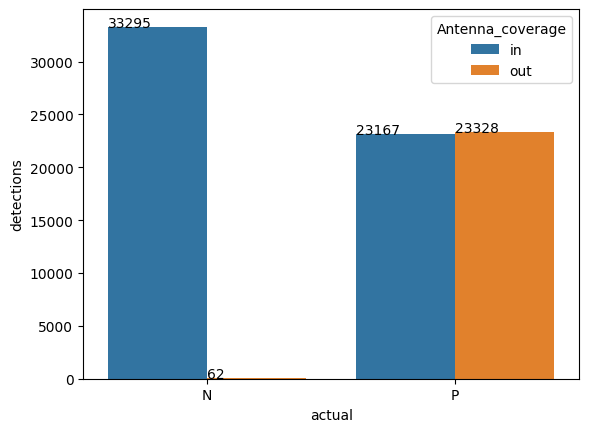

In [ ]:
Bars = sns.barplot(data=temp, x='actual', y='detections', hue='Antenna_coverage')
for bar in Bars.patches[:-2]:
  xvar=bar.get_x()
  yvar=bar.get_height()
  plt.annotate(f'{int(yvar)}', (xvar, yvar))

## errors Conv1D

In [ ]:
Errors = Errors.groupby(['run', 'EPC', 'id']).size().rename('Q_error').sort_values(ascending=False).reset_index(drop=False)
Errors = pd.merge(Errors, Actuals)
Errors

,run,EPC,id,Q_error,actual
0,2023-10-07 13:03:27,AD3830770CCDD0AD38300333,2,10,N
1,2023-10-07 14:01:18,AD3830770CCDD0AD383002FC,4,10,P
2,2023-10-07 13:08:43,AD3830770CCDD0AD3830027F,4,7,N
3,2023-10-07 13:03:27,AD3830770CCDD0AD383001DE,6,2,P
4,2023-10-07 13:03:27,AD3830770CCDD0AD38300482,4,1,P
5,2023-10-07 13:47:12,AD3830770CCDD0AD383004AA,6,1,P
6,2023-10-07 13:51:05,AD3830770CCDD0AD3830029F,4,1,P
7,2023-10-07 13:56:19,AD3830770CCDD0AD383002AA,2,1,N
8,2023-10-07 14:52:02,AD3830770CCDD0AD38300322,4,1,N


In [ ]:
Errors = Errors.sort_values('Q_error', ascending=False).reset_index(drop=True)
Errors

,run,EPC,id,Q_error,actual
0,2023-10-07 13:03:27,AD3830770CCDD0AD38300333,2,10,N
1,2023-10-07 14:01:18,AD3830770CCDD0AD383002FC,4,10,P
2,2023-10-07 13:08:43,AD3830770CCDD0AD3830027F,4,7,N
3,2023-10-07 13:03:27,AD3830770CCDD0AD383001DE,6,2,P
4,2023-10-07 13:03:27,AD3830770CCDD0AD38300482,4,1,P
5,2023-10-07 13:47:12,AD3830770CCDD0AD383004AA,6,1,P
6,2023-10-07 13:51:05,AD3830770CCDD0AD3830029F,4,1,P
7,2023-10-07 13:56:19,AD3830770CCDD0AD383002AA,2,1,N
8,2023-10-07 14:52:02,AD3830770CCDD0AD38300322,4,1,N


In [ ]:
Errors['clf']='Conv1D'
Errors

,run,EPC,id,Q_error,actual,clf
0,2023-10-07 13:03:27,AD3830770CCDD0AD38300333,2,10,N,Conv1D
1,2023-10-07 14:01:18,AD3830770CCDD0AD383002FC,4,10,P,Conv1D
2,2023-10-07 13:08:43,AD3830770CCDD0AD3830027F,4,7,N,Conv1D
3,2023-10-07 13:03:27,AD3830770CCDD0AD383001DE,6,2,P,Conv1D
4,2023-10-07 13:03:27,AD3830770CCDD0AD38300482,4,1,P,Conv1D
5,2023-10-07 13:47:12,AD3830770CCDD0AD383004AA,6,1,P,Conv1D
6,2023-10-07 13:51:05,AD3830770CCDD0AD3830029F,4,1,P,Conv1D
7,2023-10-07 13:56:19,AD3830770CCDD0AD383002AA,2,1,N,Conv1D
8,2023-10-07 14:52:02,AD3830770CCDD0AD38300322,4,1,N,Conv1D


In [ ]:
Errors.groupby('actual').size()

actual
N    4
P    5
dtype: int64

In [ ]:
Errors.groupby('actual') ['Q_error'].sum()

actual
N    19
P    15
Name: Q_error, dtype: int64

In [ ]:
for i, row in Errors.iterrows():
  run = row['run']
  crossing_id = row['id']
  EPC = row['EPC']
  Q_error = row['Q_error']

  tags_run = tags [ tags['run']==run ]
  tags_run_crossing = tags_run [ tags_run['crossing_id']==crossing_id ]
  print(run, crossing_id, EPC, Q_error)
  visu(tags_run, 'all', True, False)
  visu(tags_run, EPC, True, False)
  visu(tags_run_crossing, EPC, True, False)

Output hidden; open in https://colab.research.google.com to view.

## errors: rf versus Conv1D

In [ ]:
Errors_Conv1D_rf = pd.merge(Errors_rf.drop(columns=['actual']), Errors, on=['run', 'id', 'EPC'], suffixes=[ '_rf', '_Conv1D',], how='outer')
Errors_Conv1D_rf = Errors_Conv1D_rf.sort_values(['Q_error_rf', 'Q_error_Conv1D'], ascending=False)
Errors_Conv1D_rf

,run,EPC,id,Q_error_rf,clf_rf,status,Q_error_Conv1D,actual,clf_Conv1D
2,2023-10-07 13:03:27,AD3830770CCDD0AD38300333,2,10.0,rf,error,10.0,N,Conv1D
4,2023-10-07 14:01:18,AD3830770CCDD0AD383002FC,4,10.0,rf,error,10.0,P,Conv1D
3,2023-10-07 13:08:43,AD3830770CCDD0AD3830027F,4,10.0,rf,error,7.0,N,Conv1D
0,2023-10-07 12:58:43,AD3830770CCDD0AD383001CA,6,10.0,rf,error,NaN,NaN,NaN
1,2023-10-07 12:58:43,AD3830770CCDD0AD383002E3,6,10.0,rf,error,NaN,NaN,NaN
6,2023-10-07 14:52:02,AD3830770CCDD0AD38300322,4,5.0,rf,error,1.0,N,Conv1D
5,2023-10-07 12:58:43,AD3830770CCDD0AD38300475,2,5.0,rf,error,NaN,NaN,NaN
7,2023-10-07 13:08:43,AD3830770CCDD0AD3830031A,4,3.0,rf,error,NaN,NaN,NaN
8,2023-10-07 14:52:02,AD3830770CCDD0AD3830029A,4,3.0,rf,error,NaN,NaN,NaN
9,2023-10-07 12:58:43,AD3830770CCDD0AD383004AF,2,1.0,rf,error,NaN,NaN,NaN


In [ ]:
Errors_Conv1D_rf ['Q_error_Conv1D'].sum(), Errors_Conv1D_rf ['Q_error_rf'].sum()

(34.0, 67.0)

# gpio prediction

load clf

In [752]:
filename = 'clf_EPC_gpio.pkl'
with open(filename, 'rb') as f:
  clf = pickle.load(f)
window = clf.window
columns_pivot = clf.columns_pivot
aggfunc_list = clf.aggfunc_list
Xcols_ds_forced = clf.Xcols_ds_forced

In [753]:
window, len(Xcols_ds_forced), Xcols_ds_forced, columns_pivot

(5,
 10,
 ['max_in_-2',
  'max_in_-1',
  'max_in_0',
  'max_in_1',
  'max_in_2',
  'max_out_-2',
  'max_out_-1',
  'max_out_0',
  'max_out_1',
  'max_out_2'],
 ['Antenna_coverage', 'slot_id_norm'])

In [754]:
ds_Windows = pd.DataFrame()

for run in tags ['run'].unique() :
  print(run)
  tags_run = tags [tags['run']==run]
  slot_id_min = tags_run['slot_id'].min()
  slot_id_max = tags_run['slot_id'].max()
  Slots_id_all = pd.Series(range(slot_id_min, slot_id_max))

  for Slots_id in Slots_id_all.rolling(window=window, min_periods=window):
    if len(Slots_id)==window:
      window_id = '_'.join([str(x) for x in Slots_id])
      slot_center = np.int32(Slots_id.min() + int(window/2))
      print(window_id)
      tags_window = tags_run [ tags_run['slot_id'].isin(Slots_id)  ]
#
      index_pivot = ['EPC']
      ds = make_ds(tags_window, index_pivot, value, fill_value, columns_pivot, aggfunc_list, Xcols_ds_forced)
#
      ds['run'] = run
      ds['window_id'] = window_id
      ds['slot_center'] = slot_center

      if len(ds)!= 0:
        X_test=ds.loc[:, Xcols_ds_forced]
        y_pred=clf.predict(X_test)
        ds['pred'] = y_pred

      ds_Windows = pd.concat([ds_Windows, ds], axis=0)

ds_Windows.head()

2023-10-07T12:58:43.000000000
0_1_2_3_4
1_2_3_4_5
2_3_4_5_6
3_4_5_6_7
4_5_6_7_8
5_6_7_8_9
6_7_8_9_10
7_8_9_10_11
8_9_10_11_12
9_10_11_12_13
10_11_12_13_14
11_12_13_14_15
12_13_14_15_16
13_14_15_16_17
14_15_16_17_18
15_16_17_18_19
16_17_18_19_20
17_18_19_20_21
18_19_20_21_22
19_20_21_22_23
20_21_22_23_24
21_22_23_24_25
22_23_24_25_26
23_24_25_26_27
24_25_26_27_28
25_26_27_28_29
26_27_28_29_30
27_28_29_30_31
28_29_30_31_32
29_30_31_32_33
30_31_32_33_34
31_32_33_34_35
32_33_34_35_36
33_34_35_36_37
34_35_36_37_38
35_36_37_38_39
36_37_38_39_40
37_38_39_40_41
38_39_40_41_42
39_40_41_42_43
40_41_42_43_44
41_42_43_44_45
42_43_44_45_46
43_44_45_46_47
44_45_46_47_48
45_46_47_48_49
46_47_48_49_50
47_48_49_50_51
48_49_50_51_52
49_50_51_52_53
50_51_52_53_54
51_52_53_54_55
52_53_54_55_56
53_54_55_56_57
54_55_56_57_58
55_56_57_58_59
56_57_58_59_60
57_58_59_60_61
58_59_60_61_62
59_60_61_62_63
60_61_62_63_64
61_62_63_64_65
62_63_64_65_66
63_64_65_66_67
64_65_66_67_68
65_66_67_68_69
66_67_68_69_70
67_68

,EPC,max_in_-2,max_in_-1,max_in_0,max_in_1,max_in_2,max_out_-2,max_out_-1,max_out_0,max_out_1,max_out_2,run,window_id,slot_center,pred
0,AD3830770CCDD0AD383001BD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-07 12:58:43,0_1_2_3_4,2,N
1,AD3830770CCDD0AD383001BE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-07 12:58:43,0_1_2_3_4,2,N
2,AD3830770CCDD0AD383001BF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-07 12:58:43,0_1_2_3_4,2,N
3,AD3830770CCDD0AD383001C2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-07 12:58:43,0_1_2_3_4,2,N
4,AD3830770CCDD0AD383001C3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-07 12:58:43,0_1_2_3_4,2,N


In [755]:
ds_Windows = ds_Windows.groupby(['run', 'window_id', 'slot_center', 'pred']).size().unstack('pred', fill_value=0).reset_index(drop=False)
ds_Windows['slot_center'] = np.int32(ds_Windows['slot_center'])
ds_Windows = ds_Windows.sort_values(['run', 'slot_center']).reset_index(drop=True)
ds_Windows.head()

pred,run,window_id,slot_center,N,P
0,2023-10-07 12:58:43,0_1_2_3_4,2,195,0
1,2023-10-07 12:58:43,1_2_3_4_5,3,193,0
2,2023-10-07 12:58:43,2_3_4_5_6,4,190,0
3,2023-10-07 12:58:43,3_4_5_6_7,5,179,7
4,2023-10-07 12:58:43,4_5_6_7_8,6,180,6


In [756]:
ds_Windows[:20]

pred,run,window_id,slot_center,N,P
0,2023-10-07 12:58:43,0_1_2_3_4,2,195,0
1,2023-10-07 12:58:43,1_2_3_4_5,3,193,0
2,2023-10-07 12:58:43,2_3_4_5_6,4,190,0
3,2023-10-07 12:58:43,3_4_5_6_7,5,179,7
4,2023-10-07 12:58:43,4_5_6_7_8,6,180,6
5,2023-10-07 12:58:43,5_6_7_8_9,7,128,60
6,2023-10-07 12:58:43,6_7_8_9_10,8,92,96
7,2023-10-07 12:58:43,7_8_9_10_11,9,87,100
8,2023-10-07 12:58:43,8_9_10_11_12,10,102,84
9,2023-10-07 12:58:43,9_10_11_12_13,11,148,35


<ipython-input-757-5f74bf2e11ef>:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for run, df_run in ds_Windows.groupby(['run']):


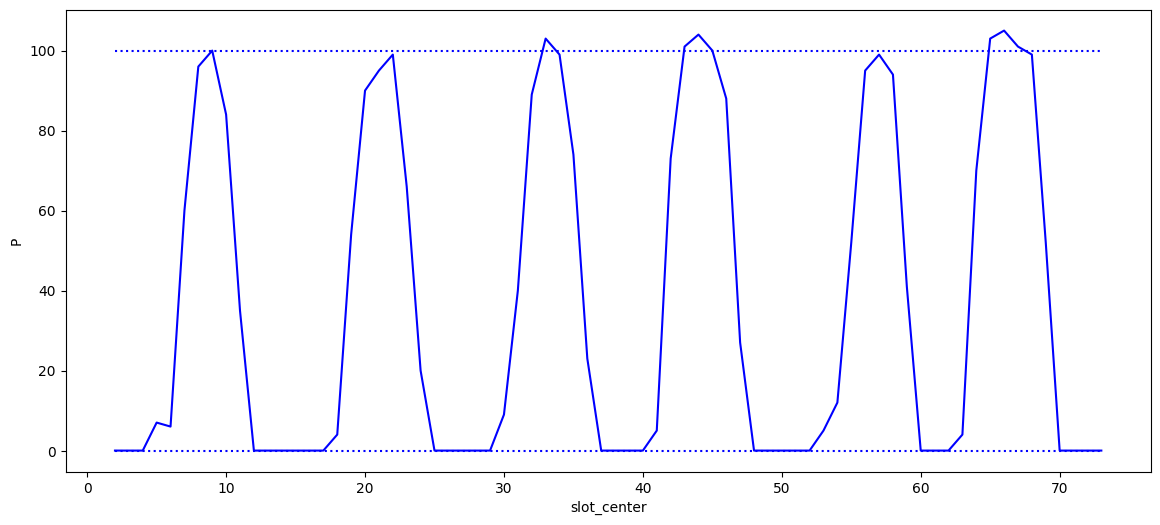

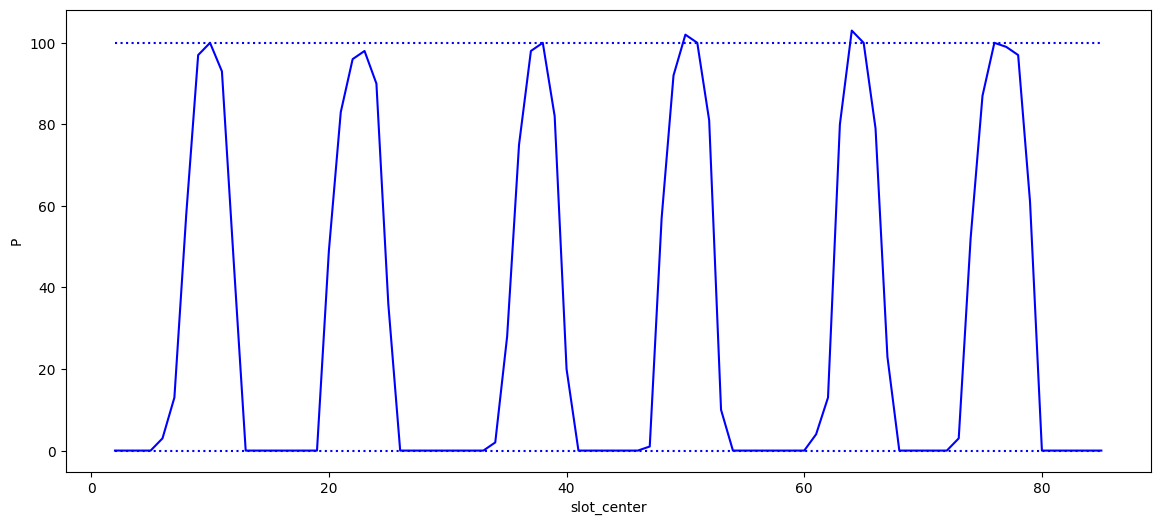

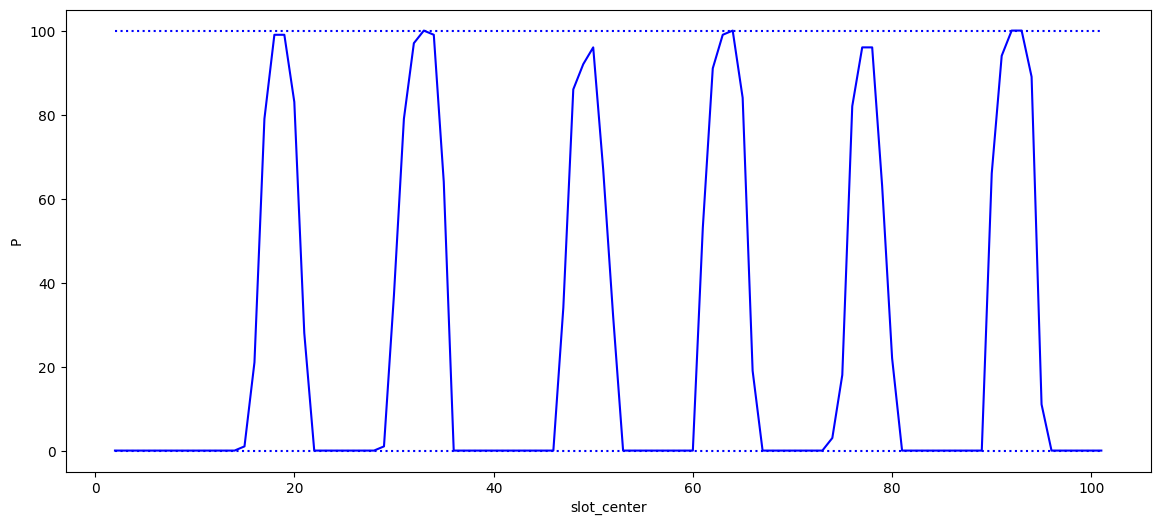

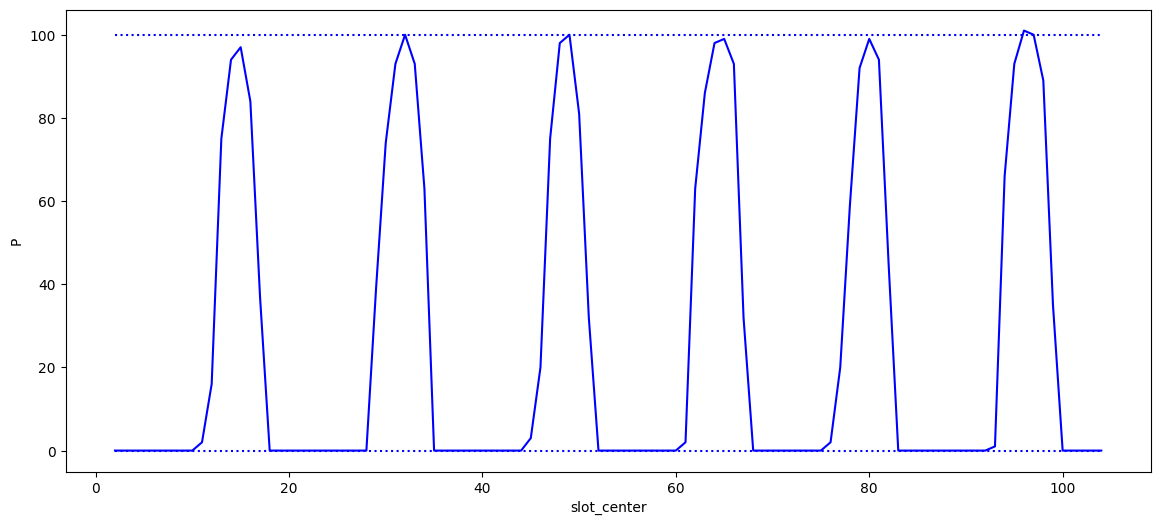

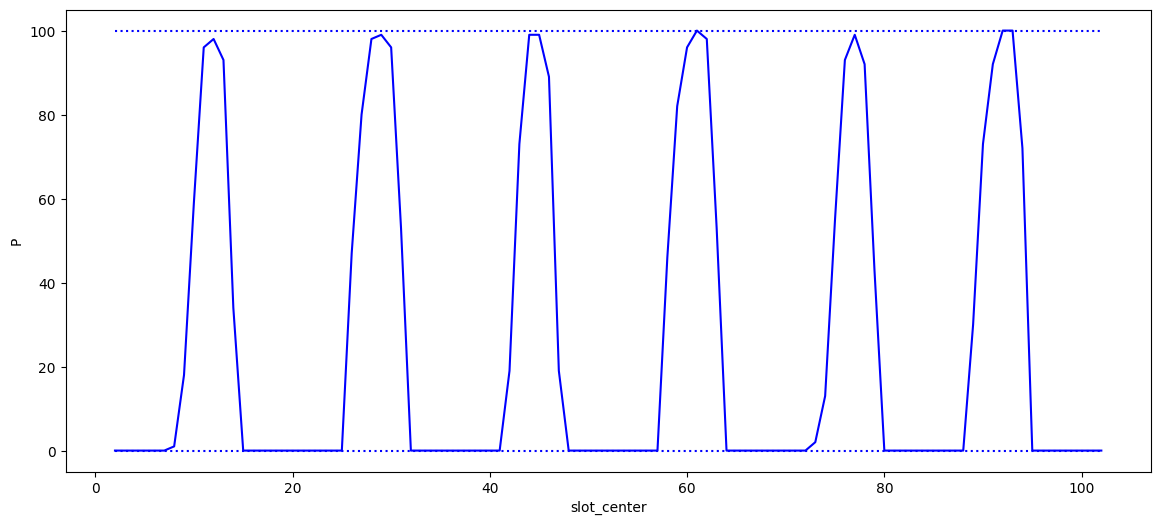

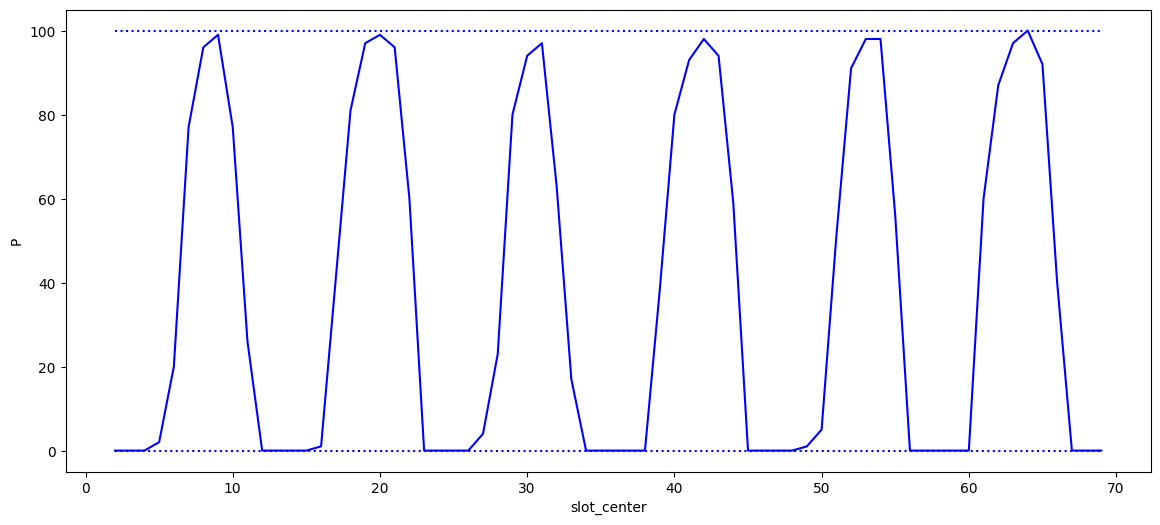

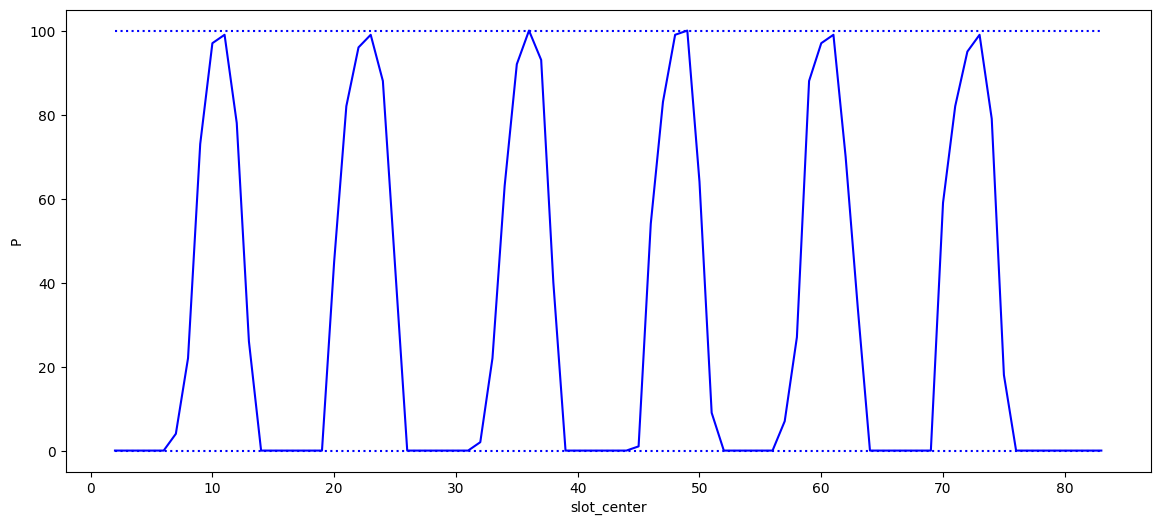

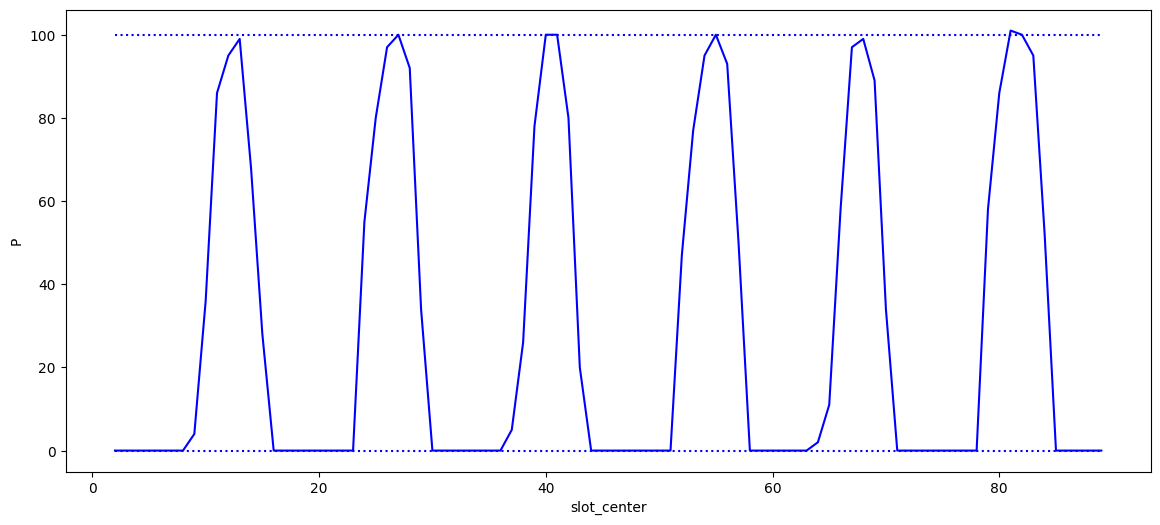

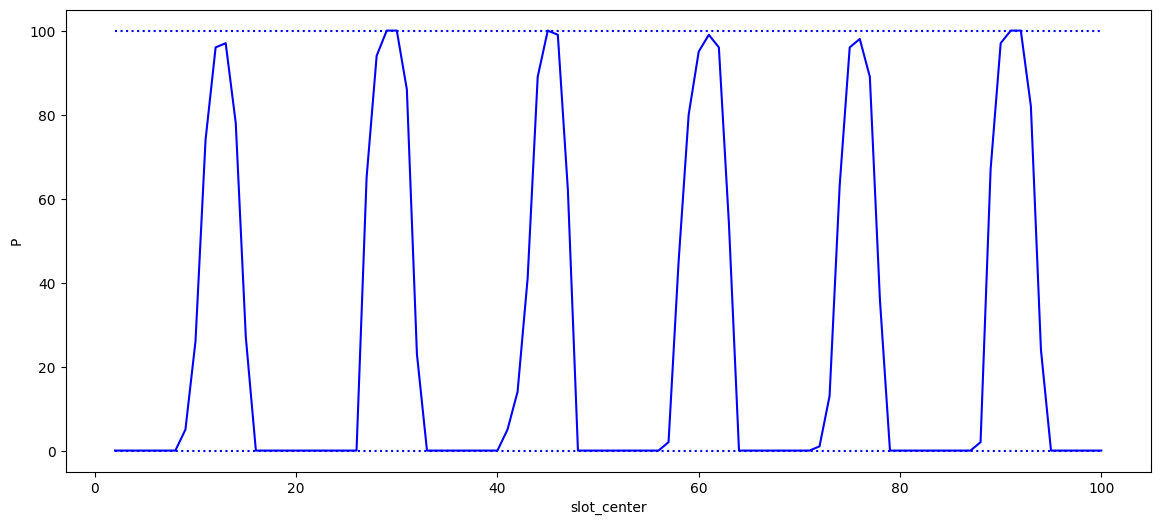

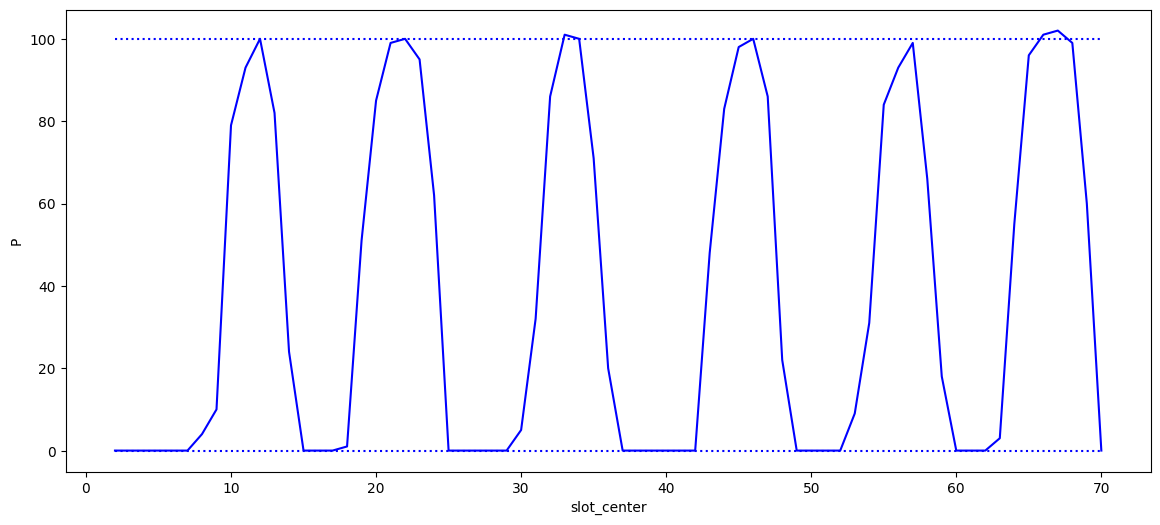

In [757]:
for run, df_run in ds_Windows.groupby(['run']):
  # print(run)
  # plt.show()

  plt.figure(figsize=(14,6))
  sns.lineplot(data=df_run, x='slot_center', y='P', color='b')
  # sns.lineplot(data=df_run, x='slot_center', y='N', color='r')

  slot_min=df_run['slot_center'].min()
  slot_max=df_run['slot_center'].max()
  plt.hlines([0], xmin=slot_min, xmax=slot_max, linestyle='dotted', color='blue')
  plt.hlines([100], xmin=slot_min, xmax=slot_max, linestyle='dotted', color='blue')

  plt.show()

In [758]:
def func(x):
  run=x['run'].values[0]
  gpio_run = gpio [gpio['run']==run]
  x = x.sort_values('slot_center')
  gpio_run = gpio_run.sort_values('slot_crossing')
  x = pd.merge_asof(x, gpio_run.drop(columns=['run', 'gpioCenter']), left_on='slot_center', right_on='slot_crossing', direction='nearest')
  return x
ds_Windows = ds_Windows.groupby('run', group_keys=False).apply(func)
ds_Windows.head()

,run,window_id,slot_center,N,P,crossing_id,slot_crossing
0,2023-10-07 12:58:43,0_1_2_3_4,2,195,0,1,9
1,2023-10-07 12:58:43,1_2_3_4_5,3,193,0,1,9
2,2023-10-07 12:58:43,2_3_4_5_6,4,190,0,1,9
3,2023-10-07 12:58:43,3_4_5_6_7,5,179,7,1,9
4,2023-10-07 12:58:43,4_5_6_7_8,6,180,6,1,9


In [759]:
ds_Windows.head()

,run,window_id,slot_center,N,P,crossing_id,slot_crossing
0,2023-10-07 12:58:43,0_1_2_3_4,2,195,0,1,9
1,2023-10-07 12:58:43,1_2_3_4_5,3,193,0,1,9
2,2023-10-07 12:58:43,2_3_4_5_6,4,190,0,1,9
3,2023-10-07 12:58:43,3_4_5_6_7,5,179,7,1,9
4,2023-10-07 12:58:43,4_5_6_7_8,6,180,6,1,9


In [760]:
def func(x):
  run=x['run'].values[0]
  Peaks, _ = find_peaks(x['P'], distance=10) #
  # Peaks, _ = find_peaks(x['P'], threshold=20)
  return x.loc[Peaks]

Pred_gpio = ds_Windows.groupby('run', group_keys=False).apply(func) .rename(columns={'slot_center':'slot_pred'})\
                      .reset_index(drop=True)
Pred_gpio[:7]


,run,window_id,slot_pred,N,P,crossing_id,slot_crossing
0,2023-10-07 12:58:43,7_8_9_10_11,9,87,100,1,9
1,2023-10-07 12:58:43,20_21_22_23_24,22,89,99,2,22
2,2023-10-07 12:58:43,31_32_33_34_35,33,92,103,3,34
3,2023-10-07 12:58:43,42_43_44_45_46,44,88,104,4,45
4,2023-10-07 12:58:43,64_65_66_67_68,66,83,105,6,67
5,2023-10-07 13:03:27,8_9_10_11_12,10,74,100,1,10
6,2023-10-07 13:03:27,21_22_23_24_25,23,68,98,2,23


In [761]:
(Pred_gpio['slot_crossing'] - Pred_gpio['slot_pred']).value_counts()

0    43
1    16
dtype: int64

In [764]:
for run, df_run in ds_Windows.groupby(['run']):

  Runs_run = Runs [ Runs['run']==run ]
  print(Runs_run[['run', 'actualDyn']])

  tags_run = tags [ tags['run']==run ]
  visu(tags_run, 'all', True, False)

  Pred_gpio_run = Pred_gpio [ Pred_gpio['run']==run ]

  plt.figure(figsize=(14,6))
  sns.lineplot(data=df_run, x='slot_center', y='P', color='b')
  # sns.lineplot(data=df_run, x='slot_center', y='N', color='r')
  plt.vlines(Pred_gpio_run['slot_crossing'], ymin=0, ymax=+100, linestyle='-', color='k')
  plt.vlines(Pred_gpio_run['slot_pred'], ymin=0, ymax=+100, linestyle='dotted', color='b')
  for i, row in Pred_gpio_run.iterrows():
    slot_crossing=row['slot_crossing']
    P=row['P']
    slot_pred=row['slot_pred']
    Delta_slot_error = slot_pred - slot_crossing
    plt.annotate(f'{P}', (slot_pred, P))
    plt.annotate(f'slot error={Delta_slot_error}', (slot_pred, P/2))


  slot_min=df_run['slot_center'].min()
  slot_max=df_run['slot_center'].max()
  plt.hlines([0], xmin=slot_min, xmax=slot_max, linestyle='dotted', color='blue')
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

# pred_EPC

In [ ]:
filename = 'clf_EPC.pkl'
with open(filename, 'rb') as f:
  clf = pickle.load(f)
window = clf.window
columns_pivot = clf.columns_pivot
aggfunc_list = clf.aggfunc_list
Xcols_ds_forced = clf.Xcols_ds_forced

In [ ]:
window, len(Xcols_ds_forced)

(11, 88)

In [ ]:
Pred_gpio

,run,window_id,slot_pred,N,P,crossing_id,slot_crossing
7,2023-10-07 12:58:43,7_8_9_10_11,9,87,100,1,9
20,2023-10-07 12:58:43,20_21_22_23_24,22,89,99,2,22
31,2023-10-07 12:58:43,31_32_33_34_35,33,96,99,3,34
43,2023-10-07 12:58:43,43_44_45_46_47,45,94,98,4,45
55,2023-10-07 12:58:43,55_56_57_58_59,57,93,99,5,57
66,2023-10-07 12:58:43,66_67_68_69_70,68,91,99,6,67
8,2023-10-07 13:03:27,8_9_10_11_12,10,75,99,1,10
21,2023-10-07 13:03:27,21_22_23_24_25,23,70,96,2,23
36,2023-10-07 13:03:27,36_37_38_39_40,38,65,100,3,38
48,2023-10-07 13:03:27,48_49_50_51_52,50,63,100,4,51


In [ ]:
ds_EPC = pd.DataFrame()

for i, row in  Pred_gpio.iterrows():
  run=row['run']
  slot_pred=row['slot_pred']
  crossing_id=row['crossing_id']
  tags_run = tags [tags['run']==run]
  Slots_id = np.arange(slot_pred-int(window/2), slot_pred+int(window/2)+1)
  Slots_id_norm = np.arange(-int(window/2), +int(window/2)+1)
  dict_Slots_norm = dict(zip(Slots_id, Slots_id_norm))
  window_id = '_'.join([str(x) for x in Slots_id])
  print(window_id)
  tags_window = tags_run [ tags_run['slot_id'].isin(Slots_id)  ].reset_index(drop=True)
  #
  # tags_window = tags_window [['Timestamp', 'EPC', 'Antenna', 'RSSIdBm']]
  # Antenna_coverage_dict = {1:'in', 2:'in', 3:'out', 4:'out'}
  # tags_window['Antenna_coverage'] = tags_window['Antenna'].map(Antenna_coverage_dict)
  # tags_window['RSSI'] = 10**6 * 10**(tags_window['RSSIdBm']/10)
  # tags_window['Timestamp'] = pd.to_datetime(tags_window['Timestamp'])
  # Slots_window = Slots [ Slots['slot_id'].isin(Slots_id)  ] [['run', 'slotStart', 'slot_id']] .reset_index(drop=True)
  # tags_window = pd.merge_asof(tags_window, Slots_window, left_on='Timestamp', right_on='slotStart', direction='nearest')
  #
  tags_window['slot_id_norm'] = tags_window['slot_id'].map(dict_Slots_norm)
#
  index_pivot = ['EPC']
  ds = make_ds(tags_window, index_pivot, columns_pivot, aggfunc_list, Xcols_ds_forced)
#
  ds['run'] = run
  ds['slot_center'] = slot_pred
  ds['window_id'] = window_id
  ds['crossing_id'] = crossing_id

  X_test=ds.loc[:, Xcols_ds_forced]
  y_pred=clf.predict(X_test)
  ds['pred'] = y_pred

  ds_EPC = pd.concat([ds_EPC, ds], axis=0)

ds_EPC.head()

4_5_6_7_8_9_10_11_12_13_14
17_18_19_20_21_22_23_24_25_26_27
28_29_30_31_32_33_34_35_36_37_38
40_41_42_43_44_45_46_47_48_49_50
52_53_54_55_56_57_58_59_60_61_62
63_64_65_66_67_68_69_70_71_72_73
5_6_7_8_9_10_11_12_13_14_15
18_19_20_21_22_23_24_25_26_27_28
33_34_35_36_37_38_39_40_41_42_43
45_46_47_48_49_50_51_52_53_54_55
60_61_62_63_64_65_66_67_68_69_70
72_73_74_75_76_77_78_79_80_81_82
14_15_16_17_18_19_20_21_22_23_24
28_29_30_31_32_33_34_35_36_37_38
45_46_47_48_49_50_51_52_53_54_55
59_60_61_62_63_64_65_66_67_68_69
72_73_74_75_76_77_78_79_80_81_82
88_89_90_91_92_93_94_95_96_97_98
10_11_12_13_14_15_16_17_18_19_20
27_28_29_30_31_32_33_34_35_36_37
44_45_46_47_48_49_50_51_52_53_54
60_61_62_63_64_65_66_67_68_69_70
75_76_77_78_79_80_81_82_83_84_85
92_93_94_95_96_97_98_99_100_101_102
7_8_9_10_11_12_13_14_15_16_17
24_25_26_27_28_29_30_31_32_33_34
40_41_42_43_44_45_46_47_48_49_50
56_57_58_59_60_61_62_63_64_65_66
72_73_74_75_76_77_78_79_80_81_82
87_88_89_90_91_92_93_94_95_96_97
4_5_6_7_8_9_10_11_12_

,EPC,len_in_-5,len_in_-4,len_in_-3,len_in_-2,len_in_-1,len_in_0,len_in_1,len_in_2,len_in_3,...,sum_out_1,sum_out_2,sum_out_3,sum_out_4,sum_out_5,run,slot_center,window_id,crossing_id,pred
0,AD3830770CCDD0AD383001BD,0,1,0,1,1,1,0,1,1,...,0.000000,0.0,0.000000,0.000000,0.0,2023-10-07 12:58:43,9,4_5_6_7_8_9_10_11_12_13_14,1,N
1,AD3830770CCDD0AD383001BE,0,0,0,0,0,0,0,0,0,...,0.158489,0.0,0.000000,0.000000,0.0,2023-10-07 12:58:43,9,4_5_6_7_8_9_10_11_12_13_14,1,N
2,AD3830770CCDD0AD383001C2,0,1,1,0,1,1,0,1,1,...,0.000000,0.0,0.000000,0.000000,0.0,2023-10-07 12:58:43,9,4_5_6_7_8_9_10_11_12_13_14,1,N
3,AD3830770CCDD0AD383001C3,1,1,0,1,1,1,0,0,0,...,0.251189,0.0,0.423398,0.223872,0.0,2023-10-07 12:58:43,9,4_5_6_7_8_9_10_11_12_13_14,1,P
4,AD3830770CCDD0AD383001C4,1,1,0,1,1,1,2,1,0,...,0.000000,0.0,0.000000,0.000000,0.0,2023-10-07 12:58:43,9,4_5_6_7_8_9_10_11_12_13_14,1,N


In [ ]:
ds_EPC = pd.merge(ds_EPC, Actuals, on='EPC')
ds_EPC.head()

,EPC,len_in_-5,len_in_-4,len_in_-3,len_in_-2,len_in_-1,len_in_0,len_in_1,len_in_2,len_in_3,...,sum_out_2,sum_out_3,sum_out_4,sum_out_5,run,slot_center,window_id,crossing_id,pred,actual
0,AD3830770CCDD0AD383001BD,0,1,0,1,1,1,0,1,1,...,0.0,0.0,0.0,0.0,2023-10-07 12:58:43,9,4_5_6_7_8_9_10_11_12_13_14,1,N,N
1,AD3830770CCDD0AD383001BD,1,0,1,2,2,1,0,1,0,...,0.0,0.0,0.0,0.0,2023-10-07 12:58:43,22,17_18_19_20_21_22_23_24_25_26_27,2,N,N
2,AD3830770CCDD0AD383001BD,1,0,1,0,1,1,0,1,0,...,0.0,0.0,0.0,0.0,2023-10-07 12:58:43,33,28_29_30_31_32_33_34_35_36_37_38,3,N,N
3,AD3830770CCDD0AD383001BD,1,1,0,1,2,0,1,0,1,...,0.0,0.0,0.0,0.0,2023-10-07 12:58:43,45,40_41_42_43_44_45_46_47_48_49_50,4,N,N
4,AD3830770CCDD0AD383001BD,0,1,1,0,1,2,2,1,1,...,0.0,0.0,0.0,0.0,2023-10-07 12:58:43,57,52_53_54_55_56_57_58_59_60_61_62,5,N,N


In [ ]:
ds_EPC.groupby(['run', 'crossing_id']).apply(lambda x:(x['actual']==x['pred']).mean()) .mean()

0.9977323314918127